<a href="https://colab.research.google.com/github/RileyWClarke/fftpca_note/blob/master/FFTPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FFTPCA

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
import sklearn
from sklearn.preprocessing import scale

In [2]:
#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

In [3]:
#from google.colab import drive
#drive.mount("/content/gdrive")

## Reading in Data

### Short Cadence Data

In [4]:
# read data

data1=np.loadtxt('Data/phot211046195r2_ssc.2m0335.dat')
data2=np.loadtxt('Data/phot210327027r2_ssc.2m0355.dat')

time1,flux1,xx1,yy1=data1[:,0],data1[:,1],data1[:,2],data1[:,3]
time2,flux2,xx1,yy2=data2[:,0],data2[:,1],data2[:,2],data2[:,3]

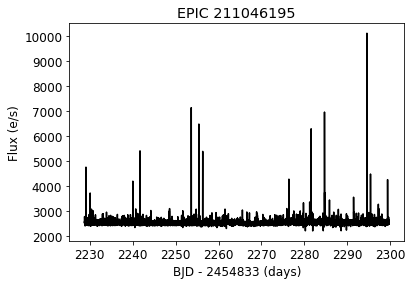

In [5]:
plt.plot(time1,flux1, c='k')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('Figures/toi1.png', dpi=100, bbox_inches='tight')

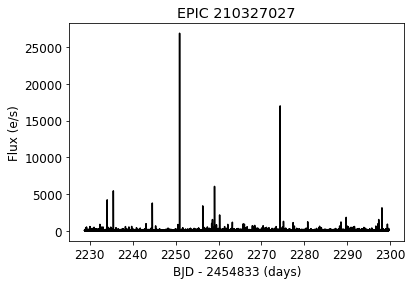

In [6]:
plt.plot(time2,flux2, c='k')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 210327027')
plt.savefig('Figures/toi2.png', dpi=100, bbox_inches='tight')

### Long Cadence Data

In [7]:
bjds = np.load('Data/bjds.npy')
fluxes = np.load('Data/fluxes.npy')
fluxerrs = np.load('Data/fluxerrs.npy')

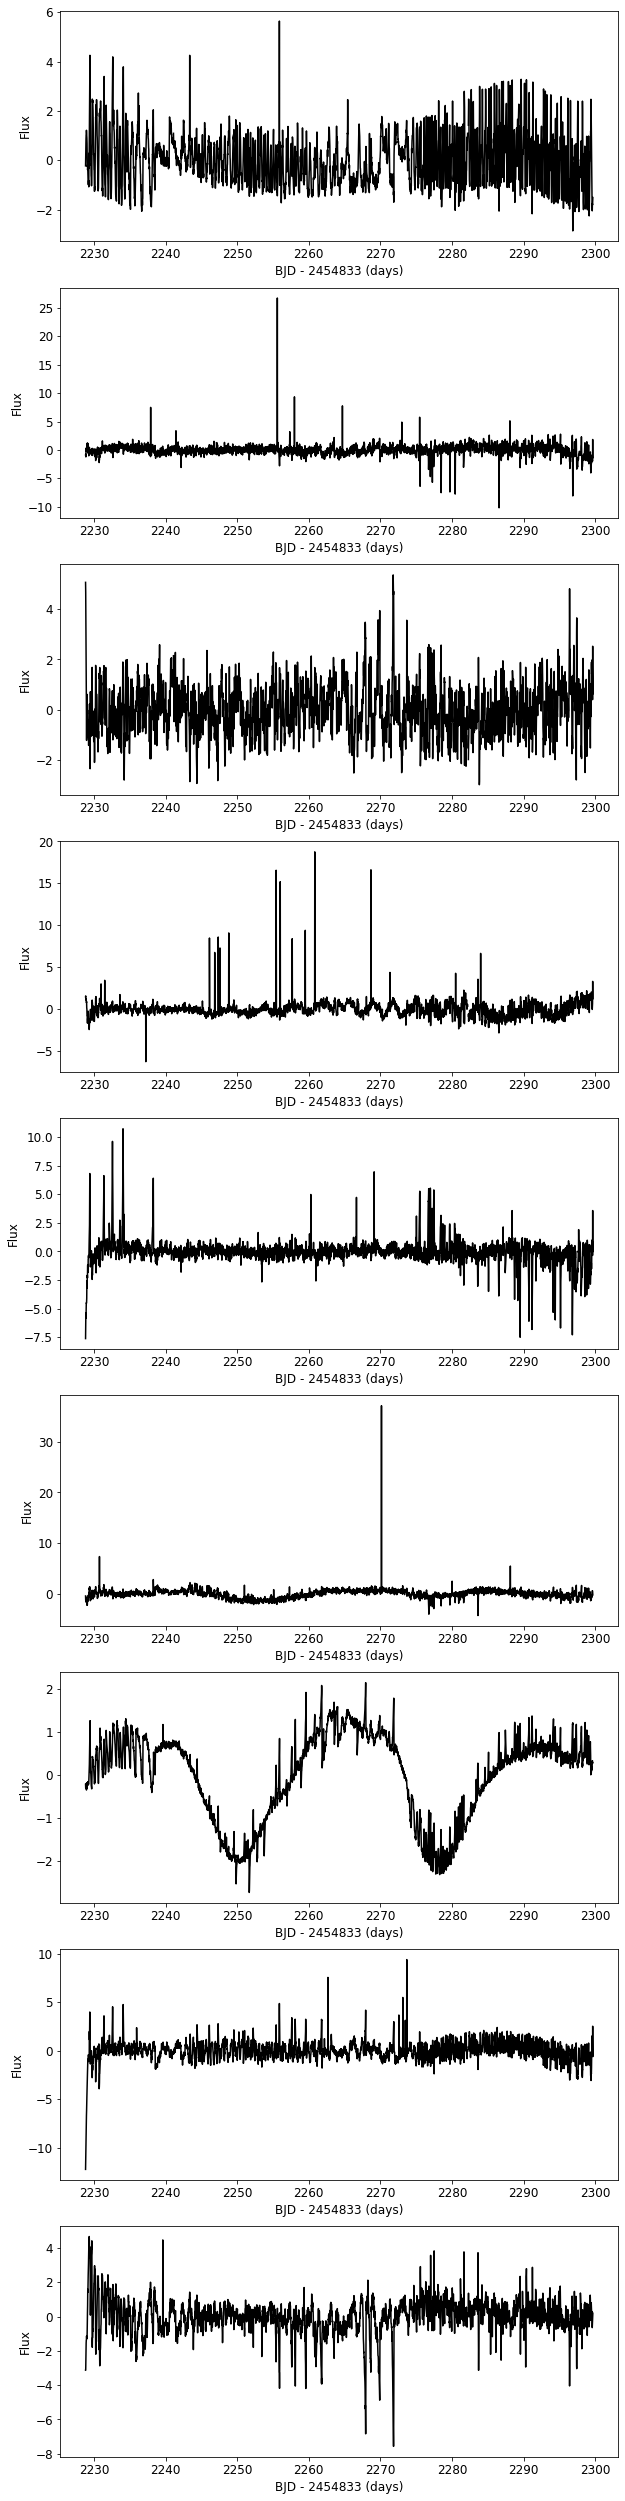

In [8]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1

# FFT Filtering

In [9]:
def invgaussian(a ,m, s, x):
    g = -a * np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [10]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, 
                  M=None, inv_box=False, gf_sig = 1, Filter='box', Plot=''):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    if ('PS' in Plot) or ('All' in Plot):
      plt.plot(freq, ps)
      plt.title("power spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Power Spectral Density')
      #plt.xlim(0,100)
      #plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()

    if ('DFT' in Plot) or ('All' in Plot):
      plt.plot(freq, spectrum)
      #plt.plot(freq[between], spectrum[between], alpha=0.5)
      plt.title("real fourier transform ")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      #plt.xlim(0,100)
      #plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()
    
    
    
    if Filter == 'box':
    
      #filtered_spectrum = spectrum.copy()
    
      if inv_box == True:
        x_1 = np.arange(0, Low_cutoff, 0.1)
        x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
        plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[lc] = 0.
        filtered_spectrum[hc] = 0.
      else:
        x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
      ig = invgaussian(1, np.median([low_cutoff,high_cutoff]), gf_sig, freq)
      filtered_spectrum = spectrum * ig
      if ('filter' in Plot) or ('All' in Plot):
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        #plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()

    if ('spec_filtered' in Plot) or ('All' in Plot):
      plt.plot(freq, filtered_spectrum, label="filtered spectrum")
      plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
      plt.title("Unfiltered vs. Filtered Spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      ldg = plt.legend(fontsize=12)
      #plt.xlim(0,100)
      #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()

    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal

    if ('signal_filtered' in Plot) or ('All' in Plot):
      fig = plt.figure(figsize=(15,10)) 
      plt.plot(t, filtered_signal, label="filtered signal")
      plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
      plt.xlabel('Time')
      plt.ylabel('Amplitude')
      plt.title("Unfiltered vs. Filtered Signal")
      #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
      plt.legend()
      #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, freq, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

In [11]:
dfts = []
pspectra = []
for i, flux in enumerate(fluxes):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum, frequency, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjds[i], flux, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra.append(np.abs(Spectrum)**2)

## Short Cadence FFT Filtering

In [12]:
flux1norm = flux1 / sigma_clip(flux1, sigma=3).mean()

In [13]:
flux2norm = flux2 / sigma_clip(flux2, sigma=3).mean()

In [14]:
Low_cutoff, High_cutoff, F_sample = 4.0, 4.2, np.diff(time1)[0]
Spectrum1, frequency1, Filtered_spectrum1, Filtered_signal1, Low_freq, High_freq = bandpass_ifft(time1, flux1norm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 0.1, Filter='Gaussian')

In [15]:
Low_cutoff, High_cutoff, F_sample = 4.0, 4.2, np.diff(time2)[0]
Spectrum2, frequency2, Filtered_spectrum2, Filtered_signal2, Low_freq, High_freq = bandpass_ifft(time2, flux2norm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 0.1, Filter='Gaussian')

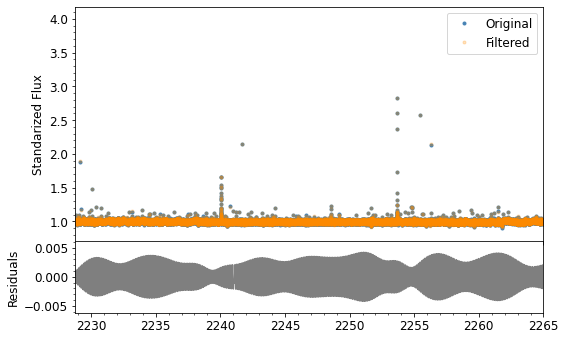

In [16]:
  fig = plt.figure(figsize=(10,5))

  res = flux1norm - Filtered_signal1

  left, width = 0.1, 0.65
  bottom, height = 0.1, 0.65

  rect_scatter = [left, bottom + 0.2, width, height]
  rect_histx = [left, bottom, width, 0.2]
  plt.subplots_adjust(hspace=0., wspace=0.1)
  ax1 = plt.axes(rect_scatter)
  axres = plt.axes(rect_histx)
  ax1.minorticks_on()
  axres.minorticks_on()
  plt.setp(ax1.get_xticklabels(),
            visible=False)

  ax1.errorbar(time1, flux1norm, color='SteelBlue', alpha=1,
                                 marker='.', fmt='.', label='Original')
  ax1.errorbar(time1, Filtered_signal1,
                                 color='DarkOrange', alpha=0.25,
                                 marker='.', fmt='.', label='Filtered')
  ax1.set_ylabel('Standarized Flux')
  ax1.legend(fontsize=12)

  axres.plot(time1, res, color='k', alpha=0.5)
  axres.set_ylabel('Residuals')

  ax1.set_xlim(time1[0], 2265)
  #ax1.set_ylim(-2,2)
  axres.set_xlim(time1[0], 2265)
  #axres.set_ylim(-0.5,0.5)

plt.savefig('Figures/resids.png', dpi=100, bbox_inches='tight');

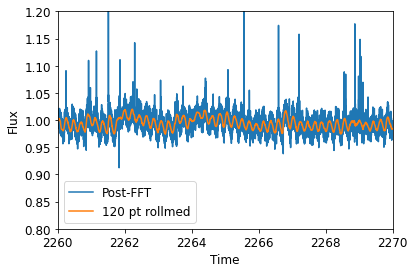

In [17]:
s = pd.Series(Filtered_signal1)
window=120
sroll = s.rolling(window, center=True).median()
plt.plot(time1, Filtered_signal1, label='Post-FFT')
plt.plot(time1, sroll.values, label='{} pt rollmed'.format(window))
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(2260,2270)
plt.ylim(0.8,1.2)
plt.legend();

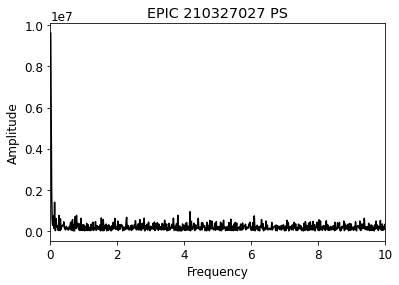

In [18]:
plt.plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 210327027 PS')
plt.xlim(0,10)
plt.savefig('Figures/toi2ps.png', dpi=100, bbox_inches='tight')

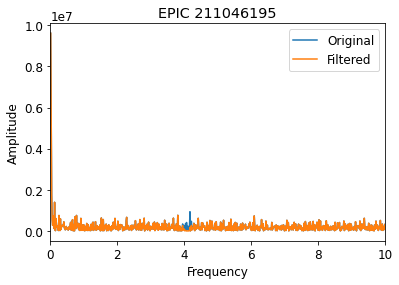

In [19]:
plt.plot(frequency2[1:],np.abs(Spectrum2[1:])**2, label='Original')
plt.plot(frequency2[1:],np.abs(Filtered_spectrum2[1:])**2, label='Filtered')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 211046195')
plt.legend(fontsize=12)
plt.xlim(0,10);

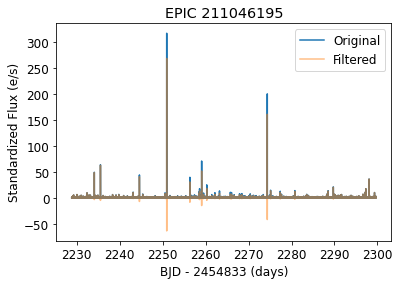

In [20]:
plt.plot(time2,flux2norm, label='Original')
plt.plot(time2[1:],Filtered_signal2,alpha=0.5, label='Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Standardized Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('Figures/toi2_filtered.png', dpi=100, bbox_inches='tight')
plt.legend(fontsize=12);

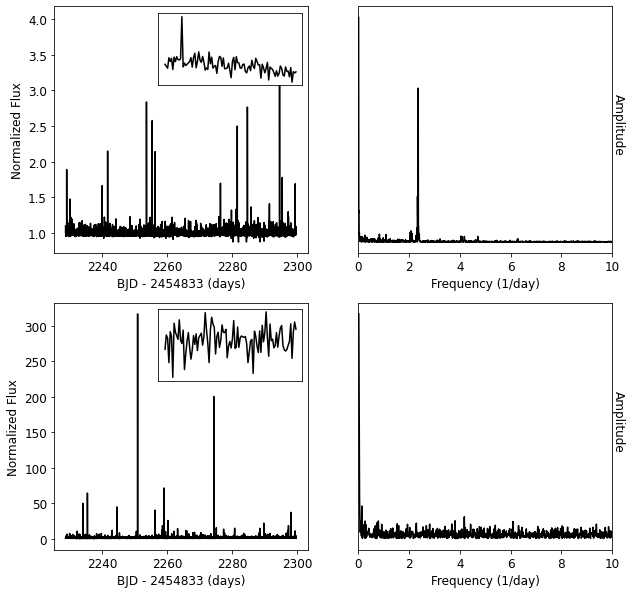

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(time1,flux1norm, c='k')
ax[1,0].plot(time2,flux2norm, c='k')
ax[0,1].plot(frequency1[1:],np.abs(Spectrum1[1:])**2, c='k')
ax[1,1].plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')

ax[0,0].set_xlabel('BJD - 2454833 (days)', fontsize = 12)
ax[0,1].set_xlabel('Frequency (1/day)', fontsize = 12)
ax[1,0].set_xlabel('BJD - 2454833 (days)', fontsize = 12)
ax[1,1].set_xlabel('Frequency (1/day)', fontsize = 12)

ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[1,0].set_ylabel('Normalized Flux', fontsize = 12)

ax[0,1].text(10, ax[0,1].set_ylim()[1]/2, 'Amplitude', va='center', fontsize = 12, rotation=-90)
ax[1,1].text(10, ax[1,1].set_ylim()[1]/2, 'Amplitude', va='center', fontsize = 12, rotation=-90)

ax[0,1].set_xlim(0,10)
ax[1,1].set_xlim(0,10)

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

#ax[0,0].vlines(time1[0],0.75,1.25, color='r')
#ax[0,0].vlines(time1[10000],0.75,1.25, color='r')
#ax[0,0].hlines(1.25, time1[0], time1[10000], color='r')
#ax[0,0].hlines(0.75, time1[0], time1[10000], color='r')

subax1 = plt.axes([0.27, 0.77, .2, .1])
subax1.plot(time1[0:100],flux1norm[0:100], color='k')
subax1.get_xaxis().set_ticks([])
subax1.get_yaxis().set_ticks([])

subax2 = plt.axes([0.27, 0.36, .2, .1])
subax2.plot(time2[0:100],flux2norm[0:100], color='k')
subax2.get_xaxis().set_ticks([])
subax2.get_yaxis().set_ticks([]);


plt.savefig('Figures/4plot.png', dpi=100, bbox_inches='tight')

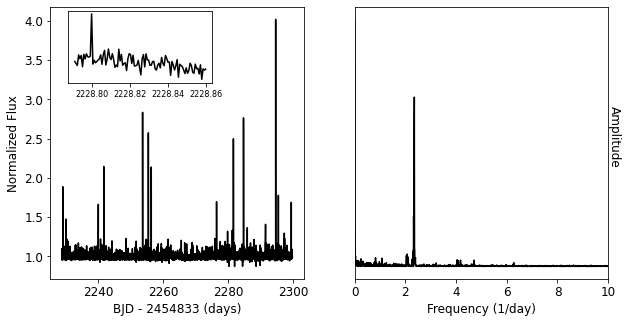

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(time1,flux1norm, c='k')
ax[1].plot(frequency1[1:],np.abs(Spectrum1[1:])**2, c='k')

ax[0].set_xlabel('BJD - 2454833 (days)', fontsize = 12)
ax[1].set_xlabel('Frequency (1/day)', fontsize = 12)
ax[0].set_ylabel('Normalized Flux', fontsize = 12)

ax[1].text(10, ax[1].set_ylim()[1]/2, 'Amplitude', va='center', fontsize = 12, rotation=-90)

ax[1].set_xlim(0,10)

ax[1].set_yticks([])

subax1 = plt.axes([0.15, 0.67, .2, .2])
subax1.plot(time1[0:100],flux1norm[0:100], color='k')
subax1.get_yaxis().set_ticks([])
subax1.ticklabel_format(useOffset=False)
subax1.tick_params(axis='both', labelsize=8)

plt.savefig('Figures/2plot.png', dpi=100, bbox_inches='tight')

# PCA with Spectra

In [23]:
from sklearn.decomposition import PCA

In [24]:
pspec_dict = {}

for j, spec in enumerate(pspectra):
  pspec_dict["spec{0}".format(j)] = spec

pspec_df = pd.DataFrame(data=pspec_dict)

In [25]:
pspec_df.head()

,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,...,spec990,spec991,spec992,spec993,spec994,spec995,spec996,spec997,spec998,spec999
0,2444.330836,3491.401379,17691.849961,24.533747,6.163901e+03,631.853491,276.295785,15020.322357,195.025521,22788.457538,...,33.260864,8.329918e+01,429.686300,3.495277e+02,10.796121,604.412834,74.000805,15.231185,1578.632726,0.325671
1,188558.097947,24932.464107,27502.736287,11596.062242,1.329584e+06,21881.098032,7824.408002,1708.935209,33900.530576,106001.638933,...,39012.940662,2.852149e+04,221522.421770,2.701112e+05,16677.137662,78130.343520,54050.845570,7015.700238,701.526990,33601.833088
2,137018.884662,40621.698347,26031.074624,99011.951142,1.027931e+05,60128.856707,74299.255923,12094.348022,523997.575650,84198.566845,...,1388.401516,7.674183e+04,411180.284071,1.482621e+05,86068.824882,164012.481497,86414.240316,6035.216574,83485.735451,23158.742652
3,8088.677230,1279.610214,25525.877039,7997.888711,1.717962e+05,15107.184941,41440.697136,7385.217256,68834.422406,119432.561355,...,1653.227609,1.331502e+05,370.357912,2.498437e+05,193504.408819,8440.866909,14802.618608,16771.383378,4520.744261,5862.505022
4,38741.302025,32673.694499,103469.748680,7106.695823,1.824596e+05,8008.003119,236357.760858,92934.117258,17320.909253,47588.485578,...,13031.507391,1.834104e+06,7710.168343,2.331563e+06,44564.275246,32945.930265,111682.212681,26327.696869,36660.220971,1539.411083


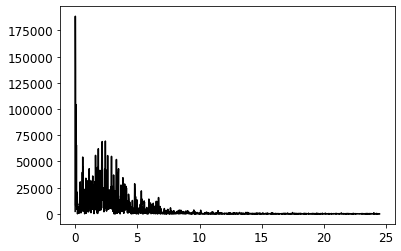

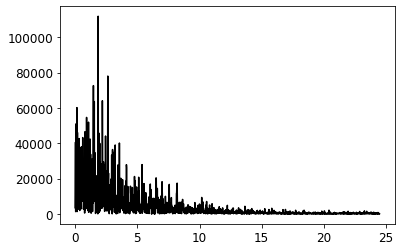

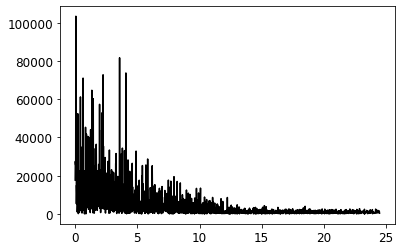

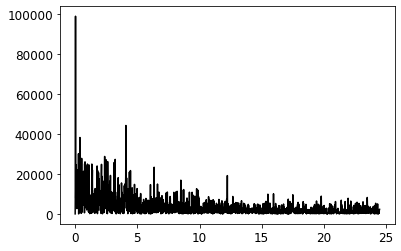

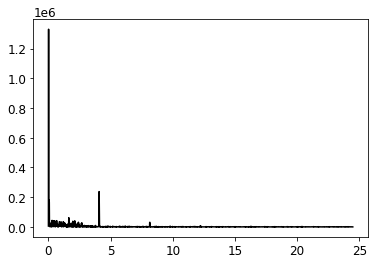

In [26]:
for i in range(5):
  plt.plot(frequency, pspec_df.values[:,i], c='k')
  plt.show()

In [27]:
'''
### Remove first values from PS:
pspec_df = pspec_df.drop([0,1,2,3,4])
pspec_df.head()
'''

'\n### Remove first values from PS:\npspec_df = pspec_df.drop([0,1,2,3,4])\npspec_df.head()\n'

In [28]:
pspec_df.shape

(1735, 1000)

In [29]:
x = pspec_df.values
x = scale(x, axis=0)

In [30]:
pca = PCA()

pca.fit(x)

X = pca.transform(x)

pca_df = pd.DataFrame(data = X)
print(pca_df.shape)
pca_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.976851,5.335109,-0.635924,0.426727,-0.149198,0.594171,1.446605,0.675921,0.419251,-0.170973,...,9.705129e-05,-1.991950e-05,1.209915e-05,1.607438e-05,-1.457954e-05,-5.352218e-06,-2.024611e-05,-1.570068e-05,-1.613461e-06,-2.141829e-07
1,204.148185,295.006662,-6.975532,40.328249,32.018923,-11.744238,-18.781720,-3.156247,-2.028993,1.815808,...,-7.305531e-08,1.089947e-08,-7.434657e-09,-1.106568e-08,2.230698e-08,5.975928e-09,2.087343e-08,1.388442e-08,2.734892e-09,-6.735684e-10
2,372.084336,-27.892496,241.148784,-66.463167,-26.688698,-5.604747,-7.383737,1.605789,-2.771667,-1.688595,...,3.325793e-08,-3.521612e-08,6.196565e-08,-4.798949e-08,1.852048e-08,-2.399046e-08,-1.306439e-08,-1.052068e-08,-1.940448e-08,2.089709e-08
3,267.782555,-62.642841,-25.544949,204.578245,-105.998911,-2.221424,-18.307529,2.020841,-3.571498,1.620010,...,-8.086416e-08,-9.126745e-08,3.000561e-08,6.304851e-08,-1.127478e-08,-1.099900e-10,-2.337174e-08,-2.024110e-08,2.418072e-08,-2.636521e-08
4,234.667100,-70.390801,-15.216099,53.341804,165.906755,108.825482,-10.195769,-12.742281,-1.464725,5.277979,...,4.346168e-08,-2.845333e-08,-1.768163e-08,3.585066e-08,-2.087022e-08,-1.040077e-08,1.059469e-08,-1.722238e-08,7.806276e-09,-1.508386e-09


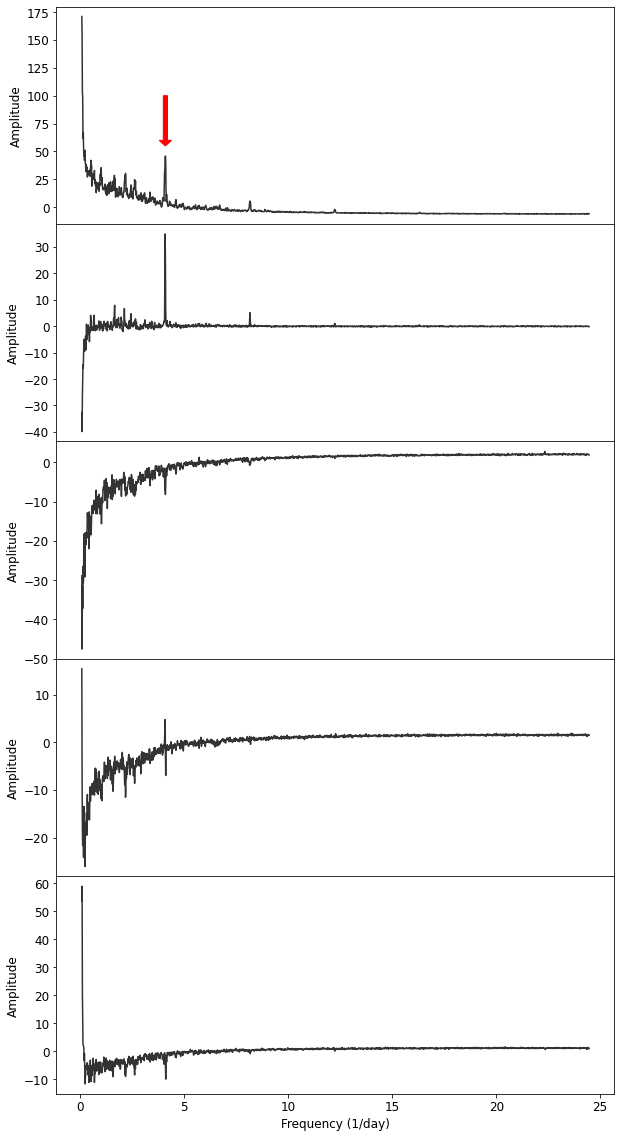

In [31]:
fig, axes = plt.subplots(5, figsize=(10,20), sharex=True)
p = 0
for i in range(5):
  axes[p].plot(frequency[5:],pca_df[i][5:], c='k', alpha=0.8)
  axes[p].set_ylabel('Amplitude')
  p += 1
axes[0].arrow(4.09, 100, 0, -40, width=0.2, head_length=5, color='red')
plt.xlabel('Frequency (1/day)')
plt.subplots_adjust(hspace=0)
plt.savefig('Figures/pspcs.png', dpi=100, bbox_inches='tight')

In [32]:
frequency[5:][np.where(pca_df[0][5:] == pca_df[0][75:].max())[0]]

array([4.0914055])

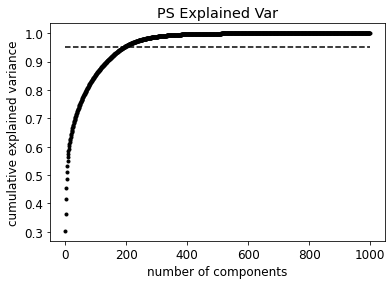

In [33]:
a = np.arange(0,len(x[0]))
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(x[0]),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PS Explained Var')
plt.savefig('Figures/expvar.png', bbox_inches='tight')

## Method 1: Removing First 2 Components entirely

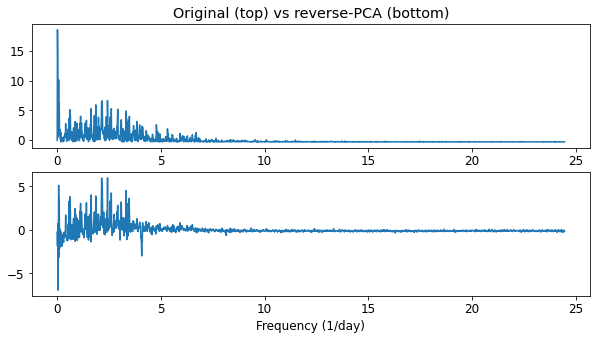

In [34]:
nComp = 200
Xhat = np.dot(pca.transform(x)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency, Xhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)');

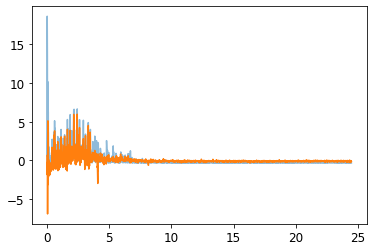

In [35]:
plt.plot(frequency,x[:,0], alpha=0.5)
plt.plot(frequency, Xhat[:,0]);

## Method 2: Bandpass Filtering First 2 Components

In [36]:
def gaussian(a, m, s, x):
    g = a * np.exp(-(m-x)**2 / s**2) 
    return g

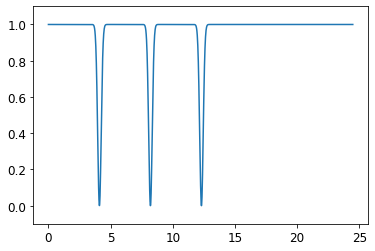

In [37]:
def hrm_gfilter(x, s, fund, nhrm=0, amps=np.ones(len(x))):

  fhrms = np.array([fund])

  for i in range(2, nhrm+2):
    fhrms = np.append(fhrms, i*fund)

  filt = np.ones(len(x))

  for hrm, amp in zip(fhrms, amps):
    filt *= invgaussian(amp,hrm,s,x) 
   # filt += gaussian(amp,hrm,s,x)

  return filt

filt = hrm_gfilter(frequency, 0.2, 4.1, 2)

plt.plot(frequency, filt)
plt.ylim(-0.1,1.1);

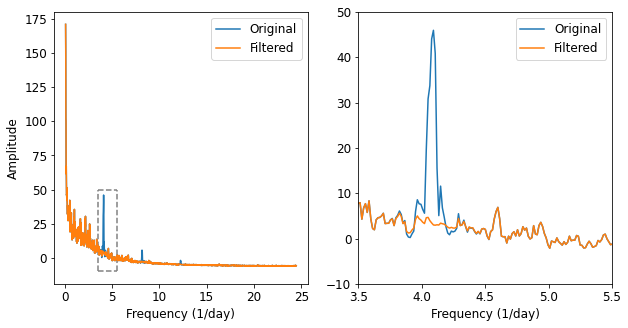

In [38]:
###Bandpass filtering:

#Some params:
fstep = np.diff(frequency).mean()
fund = 4.1
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)

pc1 = np.copy(pca_df[0])#to avoid overwriting

#Make array of fund & harmonic indices:
hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


#For each index, calculate local avg, subtract, filter, add avg back:
for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((pc1[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       pc1[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  pc1[5:] -= local_avg
  pc1[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  pc1[5:] += local_avg

#Plotting:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca_df[0][5:], label='Original')
ax[0].plot(frequency[5:], pc1[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca_df[0][5:], label='Original')
ax[1].plot(frequency[5:], pc1[5:], label='Filtered')
ax[0].set_xlabel('Frequency (1/day)')
ax[1].set_xlabel('Frequency (1/day)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend();

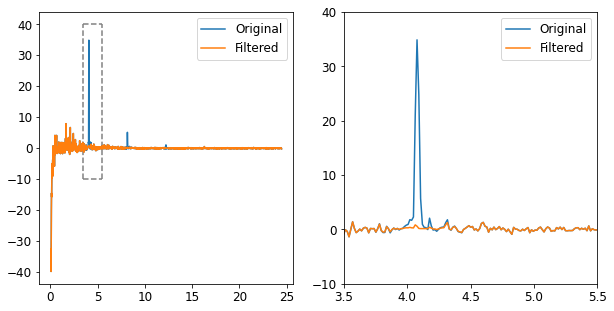

In [39]:
fstep = np.diff(frequency).mean()
fund = 4.1
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
pc2 = np.copy(pca_df[1])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((pc2[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       pc2[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  pc2[5:] -= local_avg
  pc2[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  pc2[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca_df[1][5:], label='Original')
ax[0].plot(frequency[5:], pc2[5:], label='Filtered')
ax[0].vlines(3.5,-10,40, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,40, color='grey', linestyle='--')
ax[0].hlines(40,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca_df[1][5:], label='Original')
ax[1].plot(frequency[5:], pc2[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,40)
ax[0].legend()
ax[1].legend();

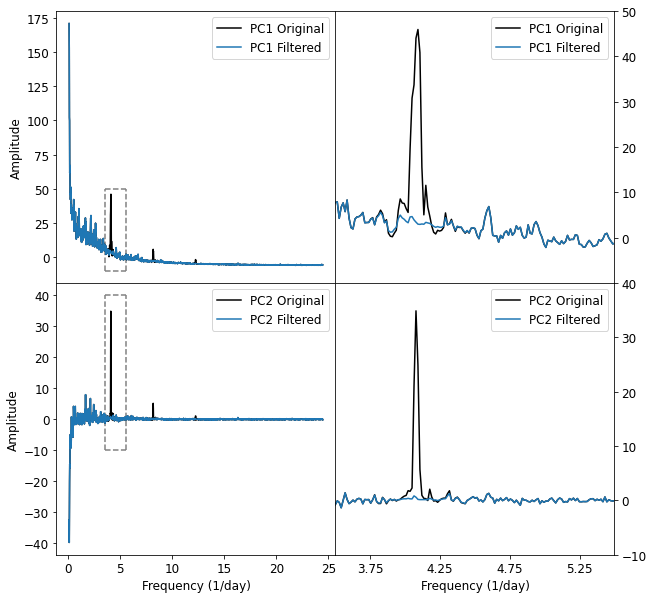

In [40]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
plt.subplots_adjust(wspace=0,hspace=0)

ax[0,0].plot(frequency[5:], pca_df[0][5:], c='k', label='PC1 Original')
ax[0,0].plot(frequency[5:], pc1[5:], label='PC1 Filtered')
ax[0,0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0,0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0,0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0,0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[0,0].set_xlabel('Frequency (1/day)')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].legend()

ax[0,1].plot(frequency[5:], pca_df[0][5:], c='k', label='PC1 Original')
ax[0,1].plot(frequency[5:], pc1[5:], label='PC1 Filtered')
ax[0,1].set_xlabel('Frequency (1/day)')
ax[0,1].set_xlim(3.5,5.5)
ax[0,1].set_ylim(-10,50)
ax[0,1].set_xticks([])
ax[0,1].set_yticks(np.arange(0,60,10))
ax[0,1].yaxis.tick_right()
ax[0,1].legend()

ax[1,0].plot(frequency[5:], pca_df[1][5:], c='k', label='PC2 Original')
ax[1,0].plot(frequency[5:], pc2[5:], label='PC2 Filtered')
ax[1,0].vlines(3.5,-10,40, color='grey', linestyle='--')
ax[1,0].vlines(5.5,-10,40, color='grey', linestyle='--')
ax[1,0].hlines(40,3.5,5.5, color='grey', linestyle='--')
ax[1,0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1,0].set_xlabel('Frequency (1/day)')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].legend()

ax[1,1].plot(frequency[5:], pca_df[1][5:], c='k', label='PC2 Original')
ax[1,1].plot(frequency[5:], pc2[5:], label='PC2 Filtered')
ax[1,1].set_xlabel('Frequency (1/day)')
ax[1,1].set_xlim(3.5,5.5)
ax[1,1].set_ylim(-10,40)
ax[1,1].yaxis.tick_right()
ax[1,1].set_xticks(np.arange(3.75,5.5,.5))
ax[1,1].legend()

plt.savefig('Figures/pcfilter.png', dpi=100, bbox_inches='tight');

In [41]:
t = np.array([pc1,pc2])
filtered_transform = pca.transform(x).copy()
print(t.T.shape, filtered_transform[:,0:2].shape)
filtered_transform[:,0:2] = t.T

(1735, 2) (1735, 2)


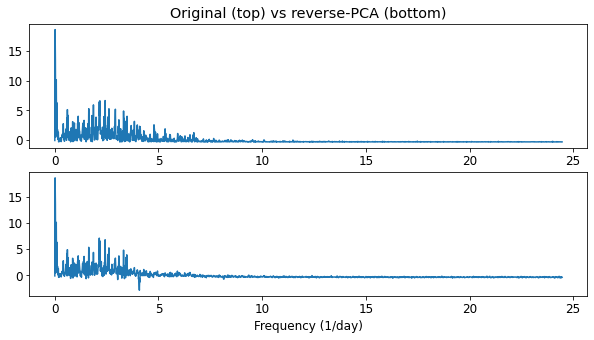

In [42]:
Xhat1 = np.dot(filtered_transform[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency,Xhat1[:,0])
#axes[0].set_ylim(-5,7)
#axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)');

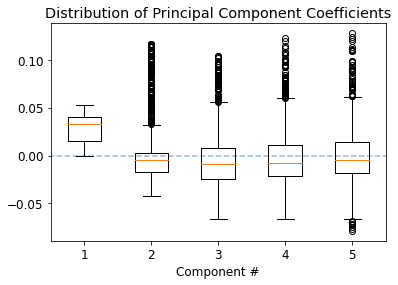

In [43]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.hlines(0, 0, 7, linestyle='--', alpha=0.5)
plt.xlabel('Component #')
plt.title('Distribution of Principal Component Coefficients')
plt.xlim(0.5,5.5)
plt.savefig('Figures/box.png', dpi=100, bbox_inches='tight')
plt.show()

In [44]:
d = {'pc1':pca.components_[0],'pc2':pca.components_[1],'pc3':pca.components_[2],'pc4':pca.components_[3],'pc5':pca.components_[4]}
coeff_df = pd.DataFrame(data=d)
coeff_df.to_csv('Data/coeffs.csv')

In [45]:
np.where(pca.components_[0] == pca.components_[0].max())[0]

array([630])

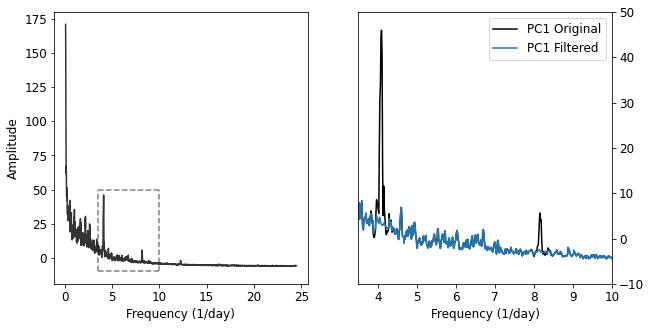

In [46]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(frequency[5:],pca_df[0][5:], c='k', alpha=0.8)
axes[0].set_ylabel('Amplitude')
axes[0].vlines(3.5,-10,50, color='grey', linestyle='--')
axes[0].vlines(10,-10,50, color='grey', linestyle='--')
axes[0].hlines(50,3.5,10, color='grey', linestyle='--')
axes[0].hlines(-10,3.5,10, color='grey', linestyle='--')
axes[0].set_xlabel('Frequency (1/day)')
#ax2.set_xticks([])
#ax2.set_xticklabels([])

axes[1].plot(frequency[5:], pca_df[0][5:], c='k',label='PC1 Original')
axes[1].plot(frequency[5:], pc1[5:], label='PC1 Filtered')
axes[1].set_xlim(3.5,10)
axes[1].set_ylim(-10,50)
#axes[1].set_xticks([])
#axes[1].set_xticklabels([])
axes[1].yaxis.tick_right()
axes[1].set_xlabel('Frequency (1/day)')
axes[1].legend()

plt.savefig('Figures/pc1_filtered.png',dpi=300, bbox_inches='tight')

# PCA with DFTs

In [47]:
dft_dict = {}


for j, dft in enumerate(dfts):
  dft_dict["dft{0}".format(j)] = dft

dft_df = pd.DataFrame(data=dft_dict)

In [48]:
y = dft_df.values
y.real = scale(y.real, axis=0)
y.imag = scale(y.imag, axis=0)

In [49]:
print(y[:,0].real.mean(), y[:,0].imag.mean())

2.047673590086744e-18 8.190694360346977e-18


In [50]:
print(y[:,0].real.std(), y[:,0].imag.std())

1.0 1.0


In [51]:
pca2 = PCA()

pca2.fit(y.real)

Y = pca2.transform(y.real)

pca2_df = pd.DataFrame(data = Y)
print(pca2_df.shape)


pca2i = PCA()

pca2i.fit(y.imag)

Yi = pca2i.transform(y.imag)

pca2i_df = pd.DataFrame(data = Yi)
print(pca2i_df.shape)

(1735, 1000)
(1735, 1000)


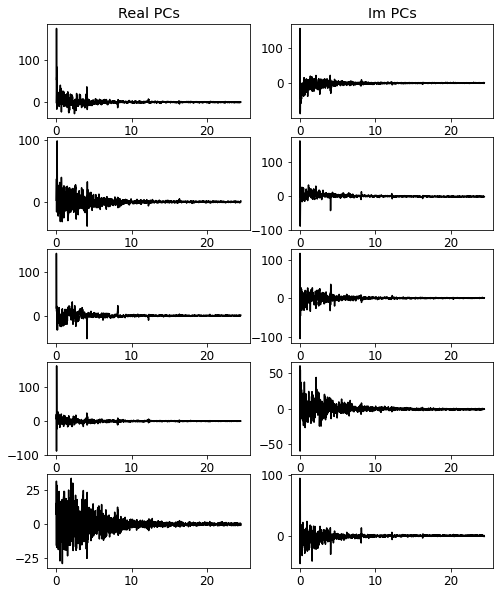

In [52]:
fig, axes = plt.subplots(5,2, figsize=(8,10))

for i in range(0,5):
  axes[i,0].plot(frequency,pca2_df[i], 'k')
  axes[i,1].plot(frequency,pca2i_df[i], 'k')
  axes[0,0].set_title('Real PCs')
  axes[0,1].set_title('Im PCs')


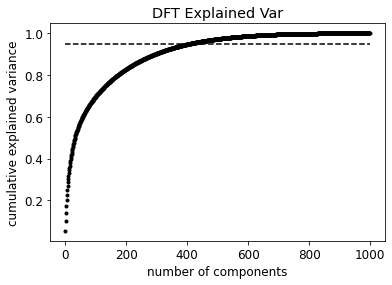

In [53]:
a = np.arange(len(y[0]))
plt.scatter(a, np.cumsum(pca2.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(a),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('DFT Explained Var')
plt.savefig('Figures/expvar2.png', bbox_inches='tight')

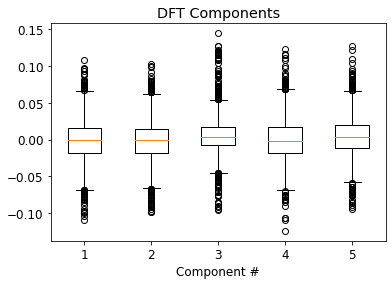

In [54]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca2.components_[0], pca2.components_[1], pca2.components_[2], pca2.components_[3],pca2.components_[4]])
plt.xlabel('Component #')
plt.title('DFT Components')
plt.savefig('Figures/box2.png', dpi=100, bbox_inches='tight')
plt.show()

## Removing 1st Component

In [55]:
'''
nComp = 400
Yhat = np.dot(pca2.transform(y.real)[:,2:nComp], pca2.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original DFT (top) vs reverse-PCA DFT (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca2_compare.png', dpi=100, bbox_inches='tight')
'''

"\nnComp = 400\nYhat = np.dot(pca2.transform(y.real)[:,2:nComp], pca2.components_[2:nComp,:])\n\nfig, axes = plt.subplots(2,1,figsize = (10,5))\naxes[0].plot(frequency,y[:,0])\naxes[1].plot(frequency, Yhat[:,0])\n#axes[0].set_ylim(-4,6)\n#axes[1].set_ylim(-4,6)\n\n\naxes[0].set_title('Original DFT (top) vs reverse-PCA DFT (bottom)')\nplt.xlabel('Frequency (1/day)')\nplt.savefig('pca2_compare.png', dpi=100, bbox_inches='tight')\n"

In [56]:
'''
plt.plot(frequency,y[:,0])
plt.plot(frequency, Yhat[:,0],alpha=0.5)
plt.xlabel('Frequency (1/day)');
'''

"\nplt.plot(frequency,y[:,0])\nplt.plot(frequency, Yhat[:,0],alpha=0.5)\nplt.xlabel('Frequency (1/day)');\n"

In [57]:
'''
Yhatc = Yhat + (1j)*y.imag
'''

'\nYhatc = Yhat + (1j)*y.imag\n'

In [58]:
'''
for i in range(0,900,100):
  plt.plot(bjds[i][1:],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i][1:],np.fft.irfft(Yhatc[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.legend(fontsize=12)
  plt.show()
  '''

"\nfor i in range(0,900,100):\n  plt.plot(bjds[i][1:],np.fft.irfft(y[:,i]), label='Original')\n  plt.plot(bjds[i][1:],np.fft.irfft(Yhatc[:,i]), alpha=0.5, label='PCA-Filtered')\n  plt.xlabel('BJD - 2454833 (days)')\n  plt.ylabel('Standardized Flux')\n  plt.legend(fontsize=12)\n  plt.show()\n  "

## Bandpass Filtering 1st Component

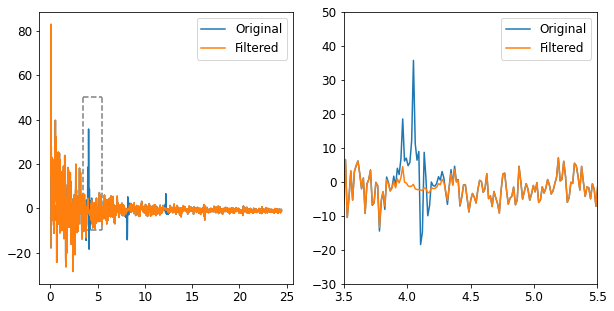

In [59]:
### BANDPASS FILTERING PC1 & PC2
#PC1 - real part
fstep = np.diff(frequency).mean()
fund = 4.09
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
dftpc1 = np.copy(pca2_df[0])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc1[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc1[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc1[5:] -= local_avg
  dftpc1[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc1[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2_df[0][5:], label='Original')
ax[0].plot(frequency[5:], dftpc1[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca2_df[0][5:], label='Original')
ax[1].plot(frequency[5:], dftpc1[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-30,50)
ax[0].legend()
ax[1].legend();

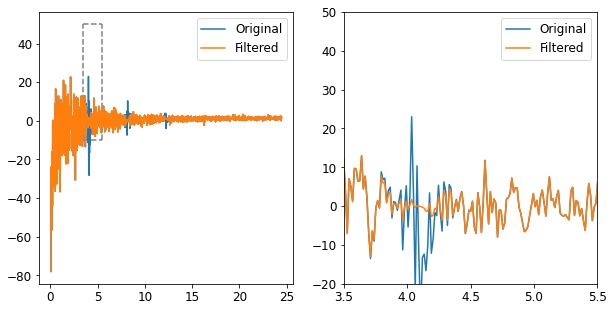

In [60]:
#PC1 - Im part
fstep = np.diff(frequency).mean()
fund = 4.09
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
dftpc1i = np.copy(pca2i_df[0])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc1i[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc1i[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc1i[5:] -= local_avg
  dftpc1i[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc1i[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2i_df[0][5:], label='Original')
ax[0].plot(frequency[5:], dftpc1i[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca2i_df[0][5:], label='Original')
ax[1].plot(frequency[5:], dftpc1i[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-20,50)
ax[0].legend()
ax[1].legend();

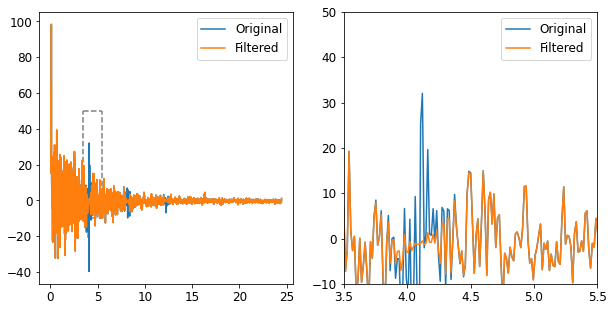

In [61]:
#PC2 - real part
fstep = np.diff(frequency).mean()
fund = 4.09
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
dftpc2 = np.copy(pca2_df[1])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc2[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc2[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc2[5:] -= local_avg
  dftpc2[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc2[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2_df[1][5:], label='Original')
ax[0].plot(frequency[5:], dftpc2[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca2_df[1][5:], label='Original')
ax[1].plot(frequency[5:], dftpc2[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend();

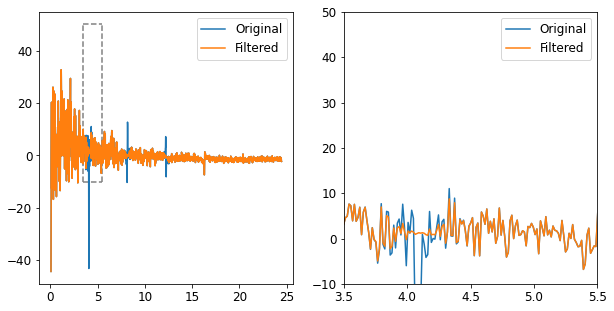

In [62]:
#PC2 - im part
fstep = np.diff(frequency).mean()
fund = 4.09
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
dftpc2i = np.copy(pca2i_df[1])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc2i[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc2i[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc2i[5:] -= local_avg
  dftpc2i[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc2i[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2i_df[1][5:], label='Original')
ax[0].plot(frequency[5:], dftpc2i[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', linestyle='--')
ax[0].vlines(5.5,-10,50, color='grey', linestyle='--')
ax[0].hlines(50,3.5,5.5, color='grey', linestyle='--')
ax[0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
ax[1].plot(frequency[5:], pca2i_df[1][5:], label='Original')
ax[1].plot(frequency[5:], dftpc2i[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend();

In [63]:
#Replace first two PCs with filtered versions

t = np.array([dftpc1, dftpc2])
ti = np.array([dftpc1i, dftpc2i])

filtered_transform2 = pca2.transform(y.real).copy()
filtered_transform2i = pca2i.transform(y.imag).copy()

filtered_transform2[:,0:2] = t.T
filtered_transform2i[:,0:2] = ti.T

In [64]:
#Create real & im components of new DFTs
nComp=400

Yhat = np.dot(filtered_transform2[:,0:nComp], pca2.components_[0:nComp,:])
Yhati = np.dot(filtered_transform2i[:,0:nComp], pca2i.components_[0:nComp,:])
'''
fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat1[:,0])
#axes[0].set_ylim(-5,7)
#axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('dftcompare.png', dpi=100, bbox_inches='tight')
'''

"\nfig, axes = plt.subplots(2,1,figsize = (10,5))\naxes[0].plot(frequency,y[:,0])\naxes[1].plot(frequency, Yhat1[:,0])\n#axes[0].set_ylim(-5,7)\n#axes[1].set_ylim(-5,7)\n\n\naxes[0].set_title('Original (top) vs reverse-PCA (bottom)')\nplt.xlabel('Frequency (1/day)')\nplt.savefig('dftcompare.png', dpi=100, bbox_inches='tight')\n"

In [65]:
#Combine real & im part

Yhat1c = Yhat + (1j)*Yhati

## Bandpass Filtering ALL Components

In [66]:
def pc_thr(dataframe, frequency, fund, threshold):
  pcs = dataframe.values
  pc_list = []
  f_ind = np.argmin(np.abs(frequency - fund))
  fstep = np.diff(frequency).mean()
  std = 0.1
  pts_per_std = int(std/fstep)

  for i, pc in enumerate(pcs):
   
    local_avg = np.mean(np.concatenate((pc[(f_ind - pts_per_std*2):(f_ind - pts_per_std*1)], 
                       pc[(f_ind + pts_per_std*1):(f_ind + pts_per_std*2)])))
    local_std = np.std(np.concatenate((pc[(f_ind - pts_per_std*2):(f_ind - pts_per_std*1)], 
                       pc[(f_ind + pts_per_std*1):(f_ind + pts_per_std*2)])))

    if np.abs(pc[f_ind]) > np.abs( local_avg * threshold * local_std ):
 
      pc_list.append(i)

    else:
      pass

  return pc_list

In [67]:
ss = pc_thr(pca2_df.T, frequency, fund=4.09, threshold=2)
len(ss)

820

In [68]:
### BANDPASS FILTERING PCs

def pc_filt(dataframe, frequency, fund, std, nhrms, subset=None):

  '''
  Takes a set of Discrete Fourier Transform PCs with a common frequency domain 
  and bandpass filters them on a given 
  fundamental frequency and associated harmonics
  with a Gaussian filter of standard deviation "std"
  '''

  #Create pcs and new_pcs
  new_pcs = []
  pcs = dataframe.values

  #Select subset of pcs if applicable:
  if subset != None:
    pcs = np.take(pcs, subset, axis=0)
  else:
    pass

  #Bandpass filter pcs:
  for i, pc in enumerate(pcs):

    fstep = np.diff(frequency).mean()
    pts_per_std = int(std/fstep)
    dftpc = np.copy(pc)  
    hrm_inds = []

    for i in range(1,nhrms+2):
      hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


    for k, ind in enumerate(hrm_inds):
      local_avg = np.mean(np.concatenate((dftpc[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

      dftpc[5:] -= local_avg
      dftpc[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
      dftpc[5:] += local_avg

    new_pcs.append(dftpc)

  #Replace modified pcs in the ensemble
  if subset != None:
    prod = dataframe.values.copy()
    for n, m in zip(range(len(subset)), subset):
      prod[m] = new_pcs[n]
    return prod

  return np.array(new_pcs)

In [69]:
real_new_pcs = pc_filt(pca2_df.T, frequency, fund=4.09, std=0.1, nhrms=2, subset=ss)
im_new_pcs = pc_filt(pca2i_df.T, frequency, fund=4.09, std=0.1, nhrms=2, subset=ss)

In [70]:
Yhat = np.dot(real_new_pcs.T[:,0:nComp], pca2.components_[0:nComp,:])
Yhati = np.dot(im_new_pcs.T[:,0:nComp], pca2i.components_[0:nComp,:])

Yhat1c = Yhat + (1j)*Yhati

In [71]:
processed = []

for i in range(1000):
  processed.append(np.fft.irfft(Yhat1c[:,i]))

processed = np.array(processed)

np.save('Data/processed_lcs_200pc', processed)

In [72]:
len(processed[0])

3468

In [73]:
len(fluxes[0])

3469

### Checking results

In [74]:
#Load processed data to verify:
dfts = []
pspectra3 = []
for i, lc in enumerate(processed):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum,_,_,_,_,_ = bandpass_ifft(bjds[i], lc, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra3.append(np.abs(Spectrum)**2)

In [75]:
pspec_dict3 = {}

for j, spec in enumerate(pspectra3):
  pspec_dict3["spec{0}".format(j)] = spec

pspec_df3 = pd.DataFrame(data=pspec_dict3)

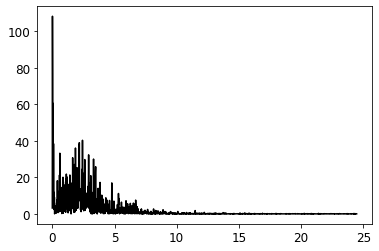

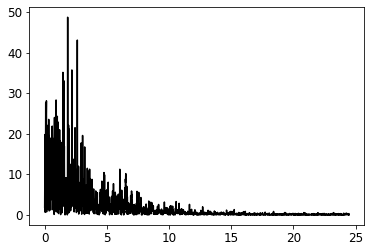

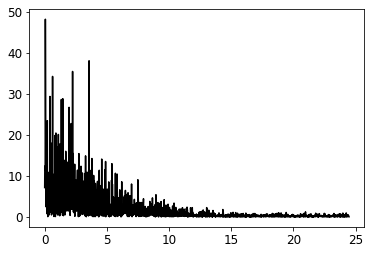

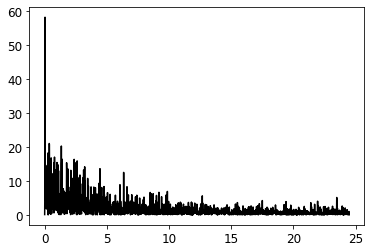

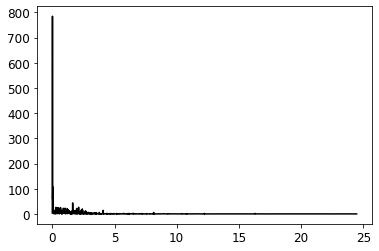

In [76]:
for i in range(5):
  plt.plot(frequency, pspec_df3.values[:,i], c='k')
  plt.show()

In [77]:
z = pspec_df3.values
z = scale(z, axis=0)

In [78]:
pca3 = PCA()

pca3.fit(z)

Z = pca3.transform(z)

pca3_df = pd.DataFrame(data = Z)
print(pca3_df.shape)
pca3_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.512551,5.044965,-0.935749,0.610163,-0.140092,0.527203,0.939077,0.521765,0.229717,-0.069371,...,-1.470419e-06,4.918964e-05,-1.577814e-05,4.591841e-05,-4.057822e-05,-1.720595e-05,-4.913092e-05,3.780796e-06,6.426869e-05,2.548028e-05
1,211.497993,301.912549,-21.327064,36.937286,33.835867,-10.341271,-14.235204,-1.451372,-0.362717,1.202250,...,-9.676909e-08,1.164690e-07,-1.663528e-07,-1.287589e-07,6.576342e-09,-8.821924e-08,1.178249e-07,2.534126e-08,-1.096940e-07,6.994497e-09
2,379.749754,-12.274764,237.592021,-74.930299,-34.885910,-8.261069,-7.292762,1.330091,-3.064308,-2.307184,...,-1.327012e-07,-8.225962e-07,-3.654884e-07,-1.481127e-07,3.190323e-07,8.279844e-07,-8.469649e-08,-2.089384e-07,-4.122805e-08,2.159885e-07
3,274.509854,-58.890311,-15.064896,209.635860,-101.029607,-1.635883,-18.596749,2.736130,-3.996940,1.211052,...,5.454709e-08,-1.646721e-07,-1.285593e-07,-2.857003e-08,3.337912e-08,3.377756e-07,-2.783994e-07,-2.441603e-08,1.998403e-07,-1.050158e-07
4,241.147549,-70.921191,-0.636905,46.451472,166.555620,110.714978,-19.946112,-13.506905,-0.636338,6.342400,...,-2.916022e-08,-1.191606e-07,2.796396e-07,-3.256349e-08,2.359827e-07,3.127559e-07,-9.534297e-08,1.217810e-07,-2.487729e-08,5.030152e-08


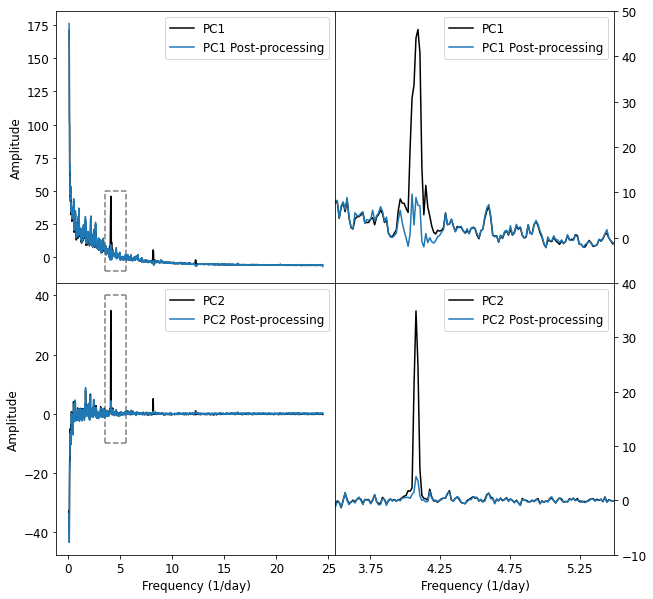

In [79]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
plt.subplots_adjust(wspace=0,hspace=0)

axes[0,0].plot(frequency[5:],pca_df[0][5:], c='k', label='PC1')
axes[0,0].plot(frequency[5:], pca3_df[0][5:], label='PC1 Post-processing')
axes[0,0].vlines(3.5,-10,50, color='grey', linestyle='--')
axes[0,0].vlines(5.5,-10,50, color='grey', linestyle='--')
axes[0,0].hlines(50,3.5,5.5, color='grey', linestyle='--')
axes[0,0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
axes[0,0].set_ylabel('Amplitude')
axes[0,0].legend()

axes[0,1].plot(frequency[5:], pca_df[0][5:], c='k',label='PC1')
axes[0,1].plot(frequency[5:], pca3_df[0][5:], label='PC1 Post-processing')
axes[0,1].set_xlim(3.5,5.5)
axes[0,1].set_ylim(-10,50)
axes[0,1].set_xticks([])
axes[0,1].set_yticks(np.arange(0,60,10))
axes[0,1].yaxis.tick_right()
axes[0,1].legend()

axes[1,0].plot(frequency[5:], pca_df[1][5:], c='k', label='PC2')
axes[1,0].plot(frequency[5:], pca3_df[1][5:], label='PC2 Post-processing')
axes[1,0].vlines(3.5,-10,40, color='grey', linestyle='--')
axes[1,0].vlines(5.5,-10,40, color='grey', linestyle='--')
axes[1,0].hlines(40,3.5,5.5, color='grey', linestyle='--')
axes[1,0].hlines(-10,3.5,5.5, color='grey', linestyle='--')
axes[1,0].set_xlabel('Frequency (1/day)')
axes[1,0].set_ylabel('Amplitude')
axes[1,0].legend()

axes[1,1].plot(frequency[5:], pca_df[1][5:], c='k', label='PC2')
axes[1,1].plot(frequency[5:], pca3_df[1][5:], label='PC2 Post-processing')
axes[1,1].set_xlabel('Frequency (1/day)')
axes[1,1].set_xlim(3.5,5.5)
axes[1,1].set_ylim(-10,40)
axes[1,1].yaxis.tick_right()
axes[1,1].set_xticks(np.arange(3.75,5.5,.5))
axes[1,1].legend()

plt.savefig('Figures/pc_post.png', dpi=100, bbox_inches='tight');

# Investigating TOIs

## Check periodicity

In [80]:
!pip install PyAstronomy

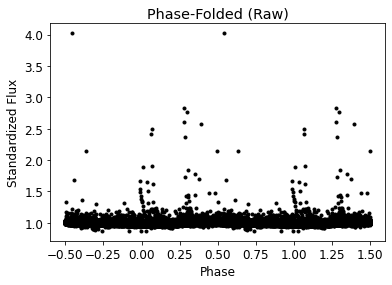

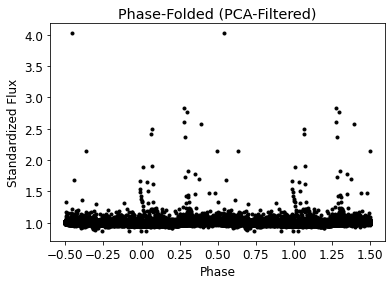

In [81]:
from PyAstronomy.pyasl import foldAt

period = 0.2185
dur = np.nanmax(time1) - np.nanmin(time1)

# Obtain the phases with respect to some
# reference point 
phases = foldAt(time1[1:], period, T0=np.nanmin(time1))

# Sort with respect to phase
# First, get the order of indices ...
sortIndi = np.argsort(phases)
# ... and, second, rearrange the arrays.
phases = phases[sortIndi]
# Plot the result


plt.plot(phases-0.5, flux1norm[sortIndi], 'k.')
plt.plot(phases+0.5, flux1norm[sortIndi], 'k.')
#plt.plot(p-0.5, quadfit, c='cyan')
#plt.plot(p+0.5, quadfit, c='cyan')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (Raw)')
#plt.xlim(-0.5,1.5)
#plt.ylim(-0.1,0.1)
#plt.savefig('phasefold1.png',dpi=100,bbox_inches='tight')
plt.show()

plt.plot(phases-0.5, Filtered_signal1[sortIndi], 'k.')
plt.plot(phases+0.5, Filtered_signal1[sortIndi], 'k.')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (PCA-Filtered)')
#plt.xlim(-0.5,1.5)
#plt.ylim(-0.1,0.1)
#plt.savefig('phasefold2.png',dpi=100,bbox_inches='tight')
plt.show()

## Model flares

In [82]:
flares = [2253.65107,
          2240.04075,
          2281.57290,
          2284.68258,
          2287.91009,
          2268.87127,
          2295.39965,
          2299.37770,
          2291.45770,
          2248.59421,
          2261.51045,
          2269.02792,
          2249.17243,
          2276.02709,
          2229.08574,
          2293.30131,
          2295.02575,
          2258.54786,
          2284.92844,
          2238.85706,
          2251.42265,
          2249.41148,
         ]

In [83]:
len(flares)

22

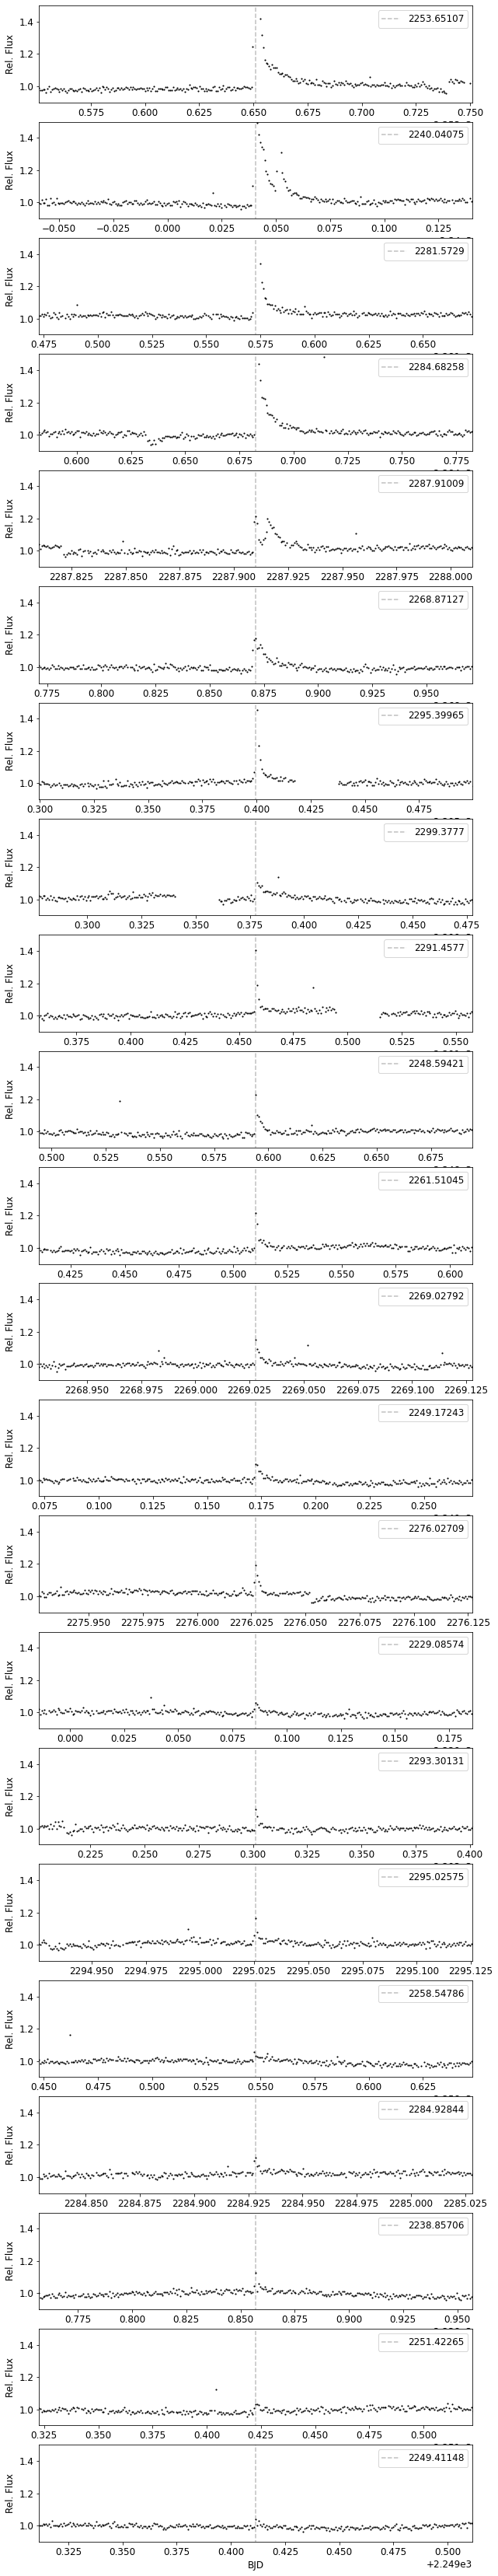

In [84]:
fig, axes = plt.subplots(22, figsize=(10,60))

for i,flare in enumerate(flares):
  axes[i].scatter(time1, Filtered_signal1, color='k', marker='.', s=5)
  axes[i].vlines(flare, -50, 50, color='k', linestyle='--', alpha=0.25, label=str(flare))
  #axes[i].vlines(flare+(1./72), -50, 50, color='k', ls='--', alpha=0.75)
  #axes[i].vlines(flare-(1./96), -50, 50, color='k', ls='--', alpha=0.75)
  axes[i].set_xlim(flare-0.1,flare+0.1)
  axes[i].set_ylim(0.9,1.5)
  axes[i].set_ylabel('Rel. Flux')
  axes[i].legend()
plt.xlabel('BJD', fontsize=12)
plt.savefig('Figures/flares.png', bbox_inches='tight')
plt.show()

## Gabor Filtering

In [85]:
def gabor1D(x, Lambda, sigma=1, nstds=3, offset=0):

  gb = np.exp(-.5 * (x ** 2 / sigma ** 2)) * np.cos(2 * np.pi / Lambda * x + offset)

  return gb

Lambda = 1


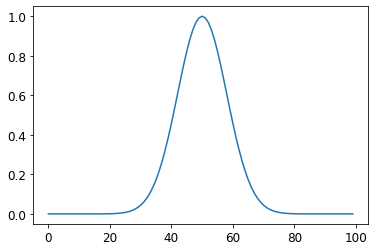

Lambda = 2


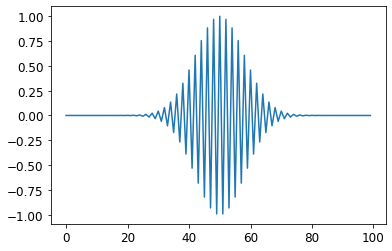

Lambda = 4


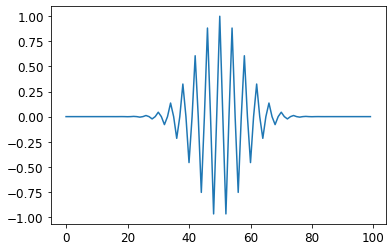

Lambda = 8


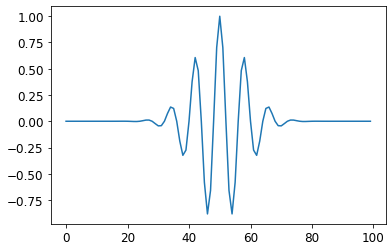

Lambda = 16


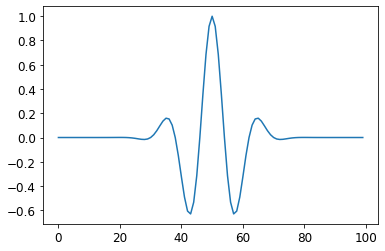

Lambda = 32


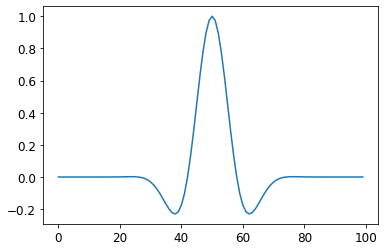

In [86]:
i=1
x = np.arange(-50,50)
while i <= 32:
  print('Lambda = {}'.format(i))
  plt.plot(gabor1D(x, Lambda=i, sigma=8, nstds=10))
  plt.show()
  i *= 2

In [87]:
bigflrs = np.array([7521, 9553, 22419, 31486, 39171, 43085, 64963, 86726, 98619])

In [88]:
#Retriving indices for mcmc targets

indlist = []
for lc in processed[::100]:
    lc_inds = []
    for i, pt in enumerate(lc):
        if pt > (5*lc.std()):
            lc_inds.append(i)
            
    indlist.append(lc_inds)
    
redlist = []
for lst in indlist:
    red_inds = []
    for i, ind in enumerate(lst):
        
        if (ind - lst[i-1]) == 1:
            pass
        else:
            red_inds.append(ind)
    redlist.append(red_inds)
redlist

[[],
 [445, 1310, 1427, 2900],
 [2102],
 [847, 883, 907, 919, 979, 1302, 1331, 1412, 1501, 1566, 1950],
 [29, 125, 182, 254, 462],
 [95, 2020, 2022],
 [],
 [],
 [],
 [526, 2118]]

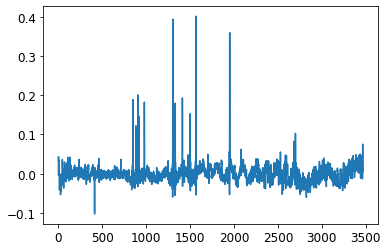

In [89]:
plt.plot(processed[300])

Flare amp = 49.3299015996681
Ringing amp = 3.6544330562524774
Noise amp = 0.9999999999999999
Ringing - Noise = -2.6544330562524774


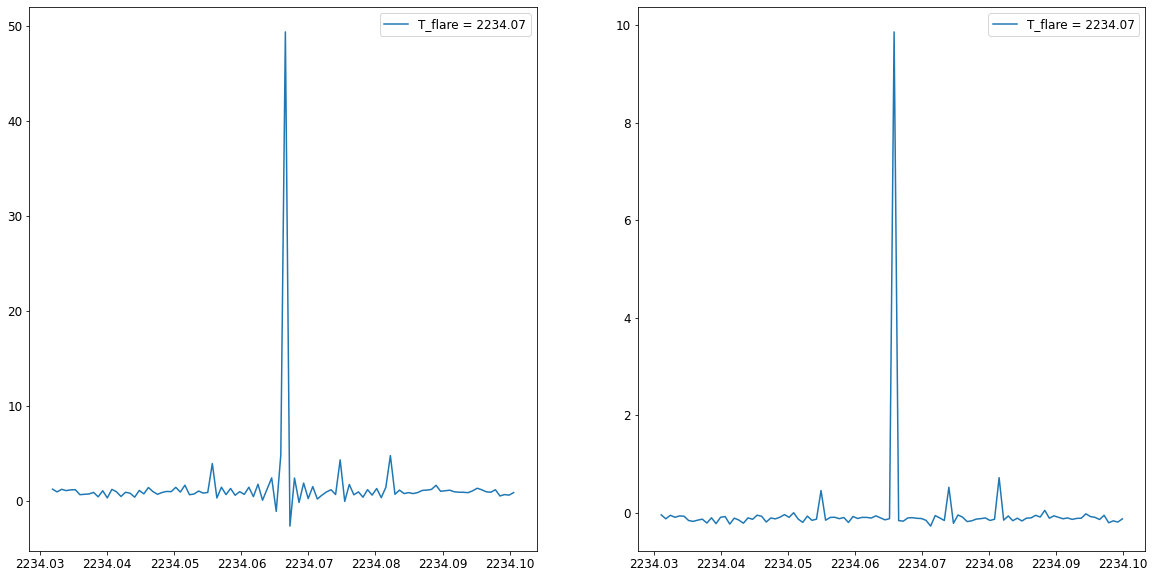

Flare amp = 63.2828582467353
Ringing amp = 5.203248547577572
Noise amp = 1.0
Ringing - Noise = -4.203248547577572


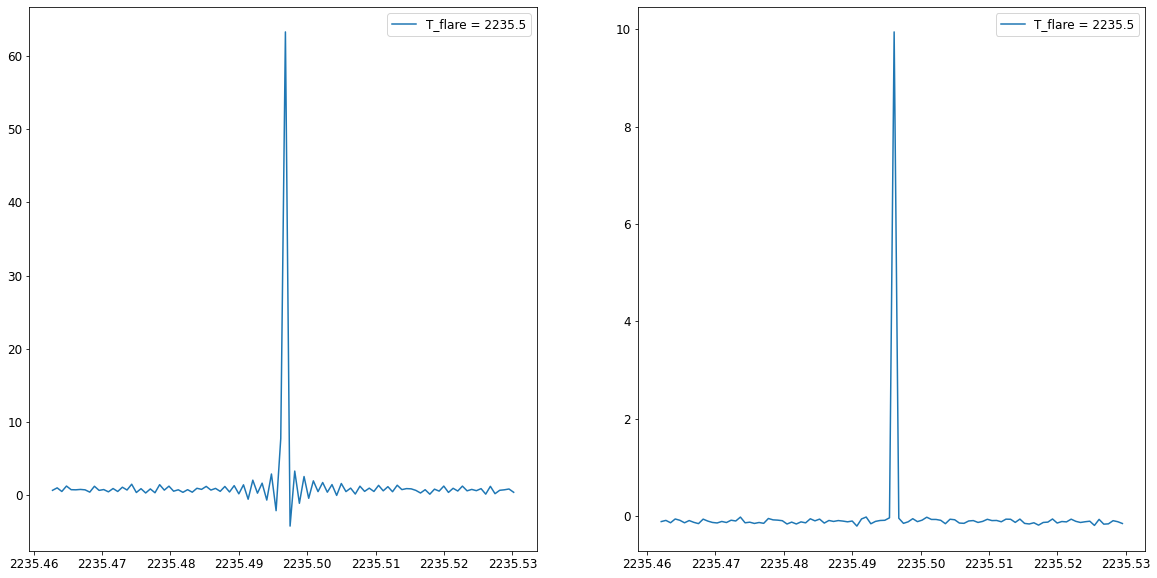

Flare amp = 41.246093486605005
Ringing amp = 7.305784572281375
Noise amp = 0.9999999999999999
Ringing - Noise = -6.305784572281375


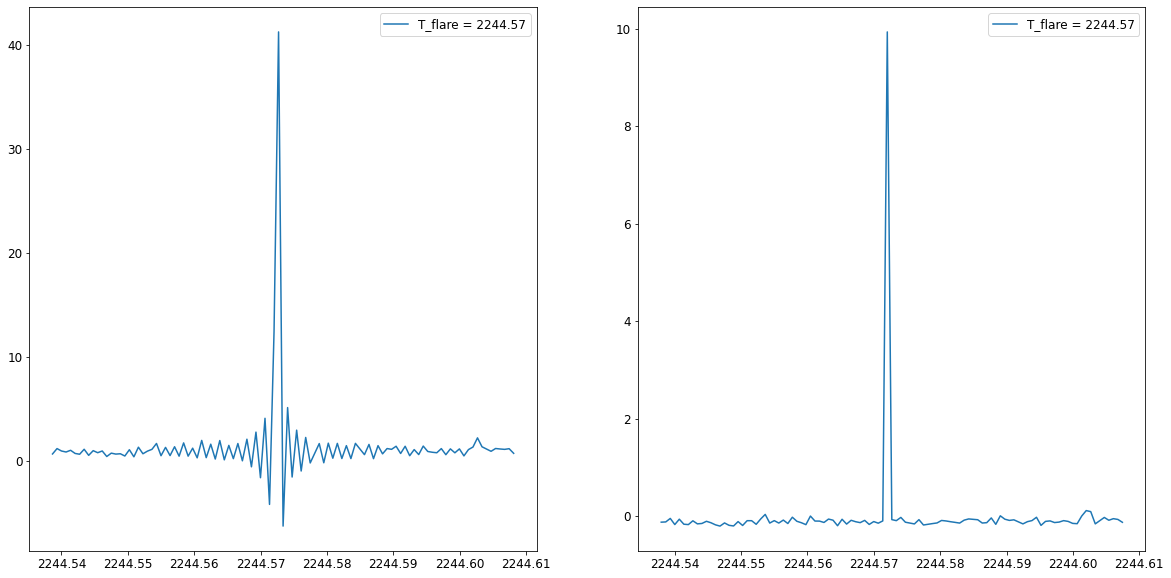

Flare amp = 268.3842795982394
Ringing amp = 63.819896805123065
Noise amp = 0.9999999999999999
Ringing - Noise = -62.819896805123065


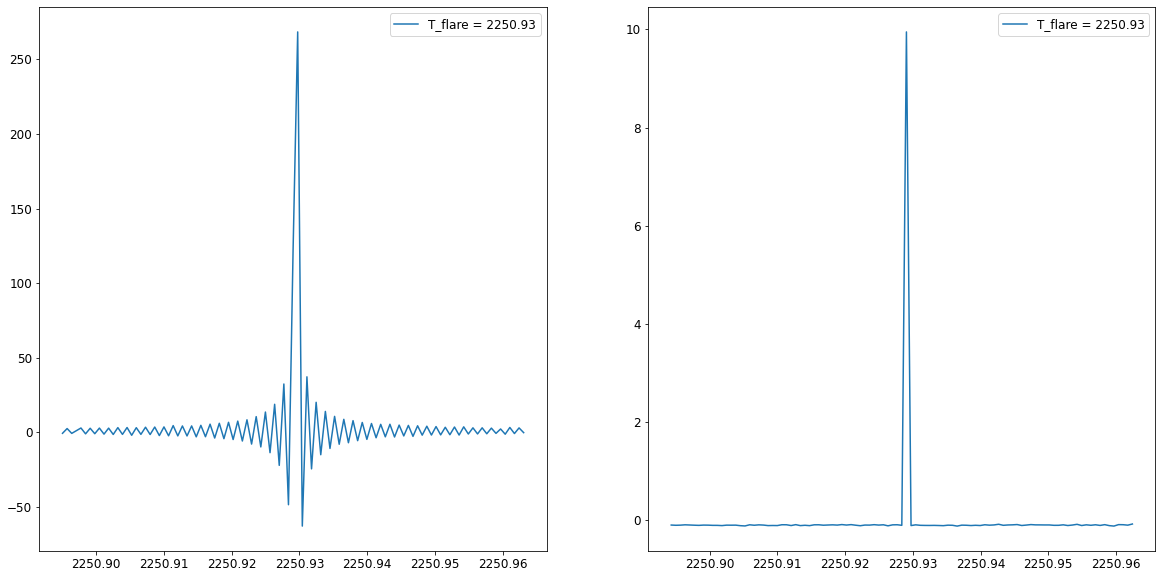

Flare amp = 31.256786352978892
Ringing amp = 8.66005620085988
Noise amp = 1.0
Ringing - Noise = -7.660056200859882


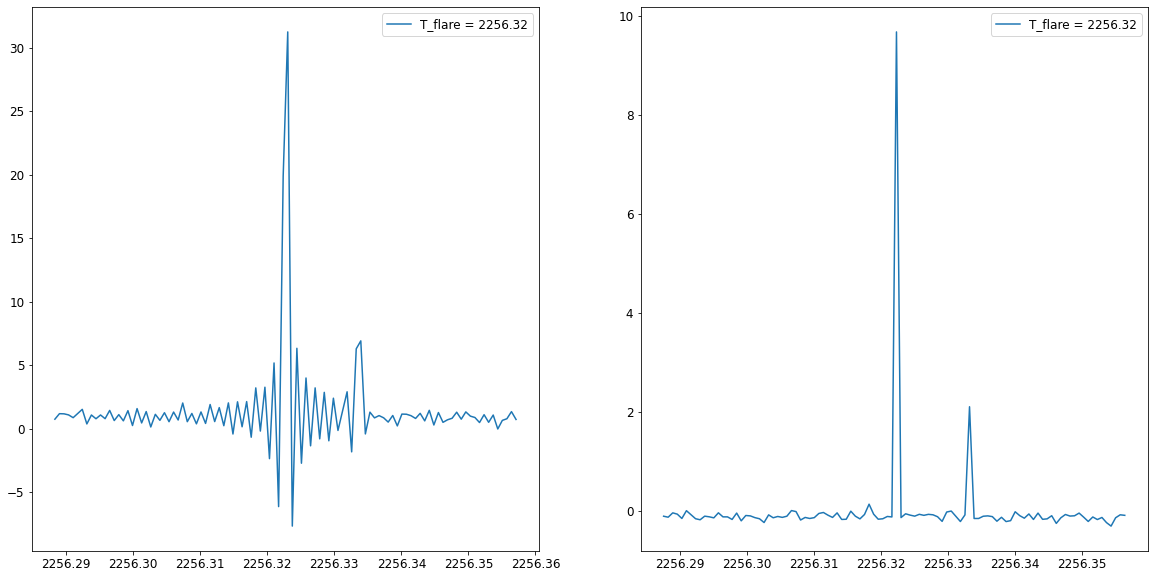

Flare amp = 52.19574795575795
Ringing amp = 15.115517529268285
Noise amp = 1.0
Ringing - Noise = -14.115517529268285


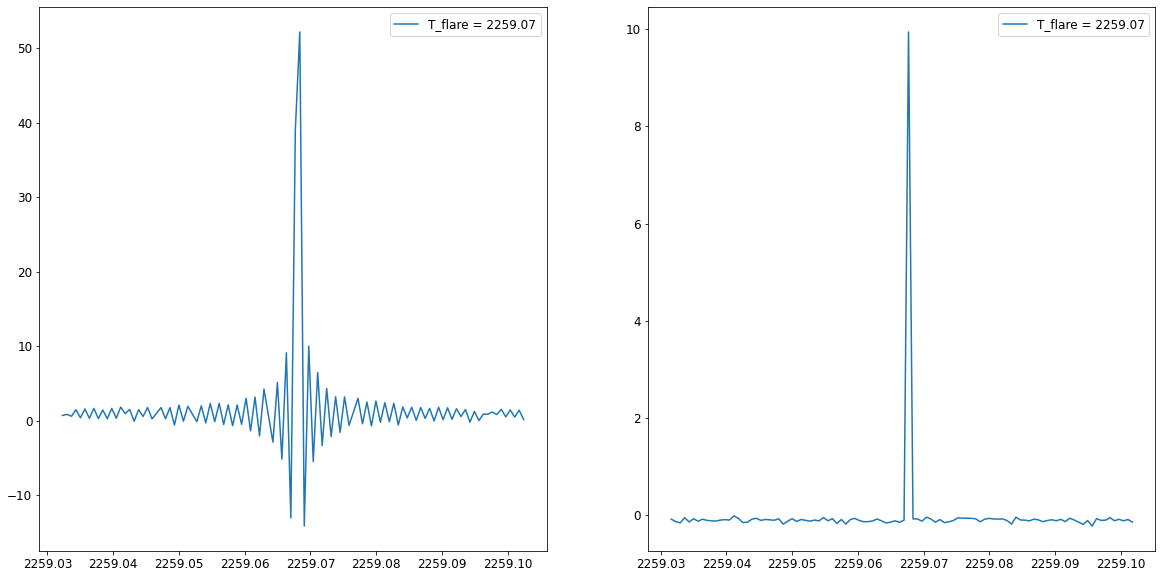

Flare amp = 161.204500807038
Ringing amp = 41.962254171169064
Noise amp = 1.0
Ringing - Noise = -40.962254171169064


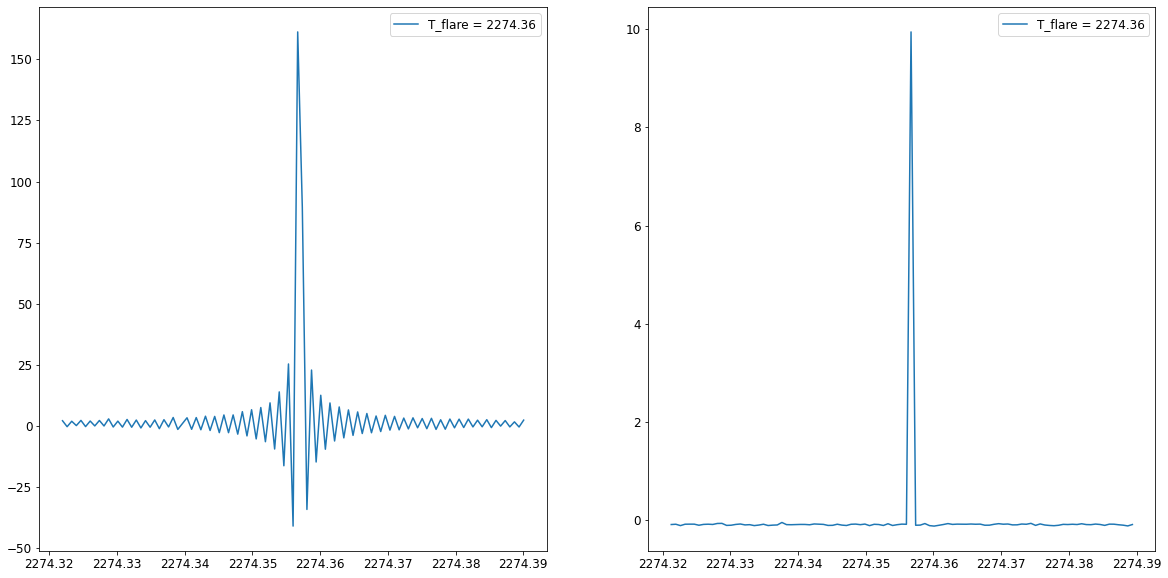

Flare amp = 21.10407256904158
Ringing amp = 2.612098903516405
Noise amp = 1.0
Ringing - Noise = -1.6120989035164048


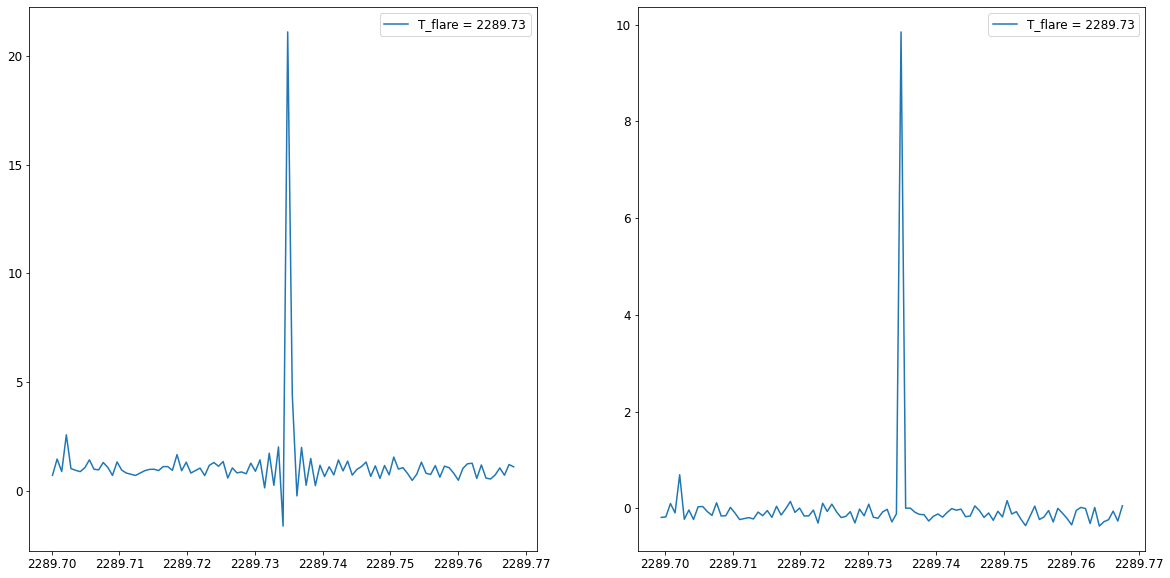

Flare amp = 36.95939877195339
Ringing amp = 0.7531386634824184
Noise amp = 1.0
Ringing - Noise = -0.24686133651758158


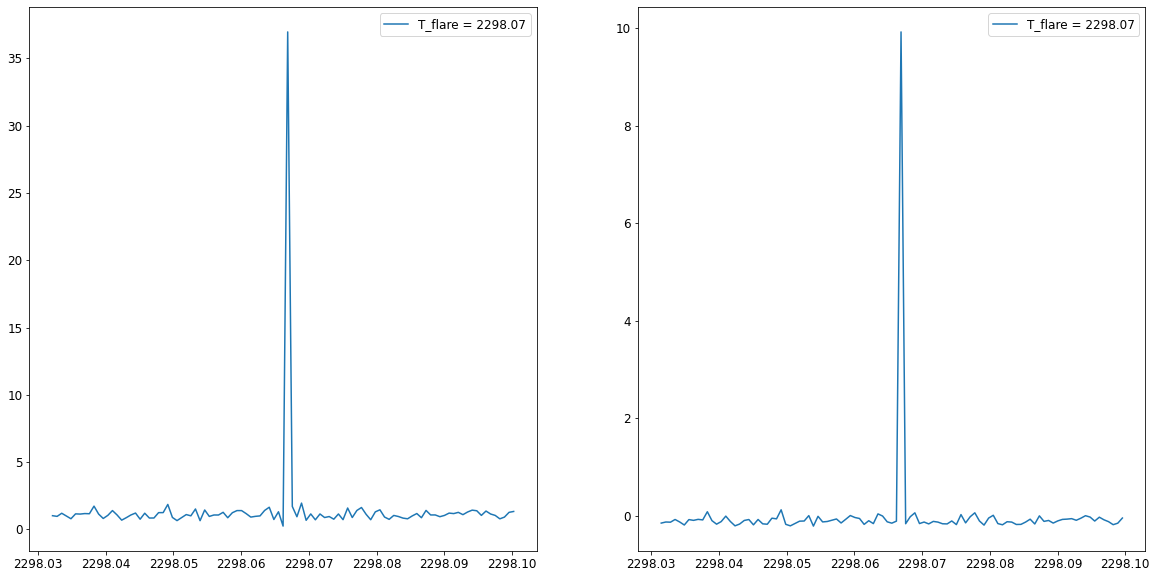

In [90]:
for flr in bigflrs:
    
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    
    peakind = flr
    
    t_flare = time2[peakind]
    
    noise = np.concatenate((scale(flux2[peakind-50:peakind-20]),scale(flux2[peakind+20:peakind+50])))
    
    ax[0].plot(time2[1:][peakind-50:peakind+50], Filtered_signal2[peakind-50:peakind+50], 
                 label='T_flare = {0:3g}'.format(t_flare))
    ax[1].plot(time2[peakind-50:peakind+50], scale(flux2[peakind-50:peakind+50]), 
                 label='T_flare = {0:3g}'.format(t_flare))
  
    print('Flare amp = {}'.format(Filtered_signal2[peakind-50:peakind+50].max()))
    print('Ringing amp = {}'.format(1-Filtered_signal2[peakind-50:peakind+50].min()))
    print('Noise amp = {}'.format(noise.std()))
    print('Ringing - Noise = {}'.format((1-np.abs(Filtered_signal2[peakind-50:peakind+50].min()) - noise.std())))
    
    ax[0].legend(loc=1)
    ax[1].legend(loc=1)
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')
    plt.show()

In [91]:
a = 30
s = 5
l = 2
offset1_true = 0 
offset2_true = 1 
n=10

peakind = np.where(Filtered_signal2 == Filtered_signal2.max())[0][0]
y = Filtered_signal2[peakind-50:peakind+50]
x = np.arange(-len(y)/2,len(y)/2)

def gmodel(x,a,s,l):

    n=10

    gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
    gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
    gabor = np.concatenate((gabor1[offset1_true:int(len(y)/2)], np.zeros(offset1_true), 
                          np.zeros(offset2_true), gabor2[int(len(y)/2):len(y)-offset2_true]))

    return gabor



In [92]:
yred = y - gmodel(x,a,s,l)
np.where(yred == yred.max())[0][0]

50

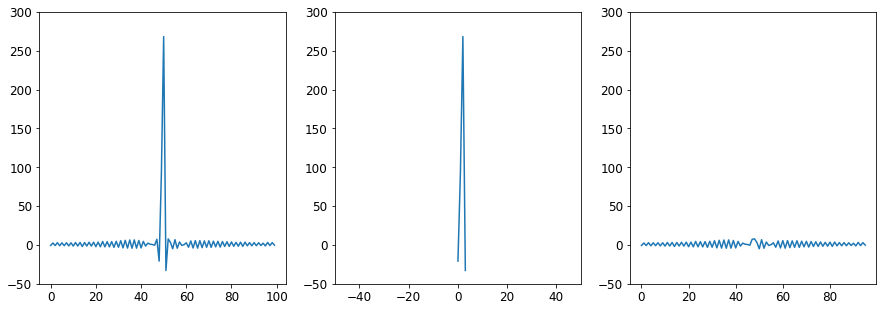

In [93]:
flrmask = np.ones_like(yred, dtype='bool')
mask_l = 48
mask_r = 52
flrmask[mask_l:mask_r] = False

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(yred)
ax[1].plot(yred[~flrmask])
ax[2].plot(yred[flrmask])

ax[0].set_ylim(-50,300)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,300)
ax[2].set_ylim(-50,300);

## Gabor Optimization

In [94]:
!pip install emcee

In [95]:
!pip install corner

In [96]:
import emcee
import corner
from scipy.optimize import minimize

In [97]:
np.nanmean(np.diff(bjds[500]))

0.020431776674967483

In [224]:
def gabor_mcmc(time, lightcurve, flare_ind, plotting=False):

    y = lightcurve[flare_ind-50:flare_ind+50]
    x = np.arange(-len(y)/2,len(y)/2)
    
    offset_fctr = np.nanmean(np.diff(time))
    a_true = 0.2
    s_true = 5
    l_true = 2
    m_true = np.mean(y[:30])
    offset1_true = 0 * offset_fctr
    offset2_true = 1 * offset_fctr
    n=10
    
    def gmodel(x,a,s,l,offset1,offset2):

        gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
        gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
        gabor = np.concatenate((gabor1[int(offset1 / offset_fctr):int(len(y)/2)], 
                          np.zeros(int(offset1 / offset_fctr)), 
                          np.zeros(int(offset2 / offset_fctr)), 
                          gabor2[int(len(y)/2):len(y)-int(offset2 / offset_fctr)]))
        return gabor

    def log_likelihood(theta, x, y):
        if len(theta) == 4:
            a,s,l,m = theta
            offset1 = offset1_true
            offset2 = offset2_true
        if len(theta) == 6:
            a, s, l, m, offset1, offset2 = theta

        model = gmodel(x,a,s,l,offset1,offset2)
        yred = y - model
        pred = np.zeros_like(yred)[flrmask] + m # put NaNs in here @ flare
        return -0.5 * np.nansum((yred[flrmask] - pred) ** 2)
    
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([a_true, s_true, l_true, m_true]) + 0.1 * np.random.randn(4)
    soln = minimize(nll, initial, args=(x, y))
    a_ml, s_ml, l_ml, m_ml = soln.x

    print("Maximum likelihood estimates:")
    print("a = {0:.3f}".format(a_ml))
    print("s = {0:.3f}".format(s_ml))
    print("l = {0:.3f}".format(l_ml))
    print("m = {0:.3f}".format(m_ml))

    def log_prior(theta):
        a, s, l, m, offset1, offset2 = theta
        if 0.0 < m < 50.0 and 0 < offset1 < (10 * offset_fctr) and 0 < offset2 < (10 * offset_fctr):
        #if 0.0 < a < 50.0 and 0.0 < s < 10.0 and 0.0 < l < 20.0 and 0.0 < m < 5.0 and 0 < offset1 < (10 * offset_fctr) and 0 < offset2 < (10 * offset_fctr):
            return 0.0
        print('hit prior!')
        return -np.inf
    
    def log_probability(theta, x, y):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y)
    
    soln6 = np.append(soln.x, [offset1_true, offset2_true])
    
    ###MCMC
    pos = soln6 + 1e-3 * np.random.randn(128, 6)
    nwalkers, ndim = pos.shape
    print(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
    sampler.run_mcmc(pos, 1000, progress=True);
    
    if plotting:
        fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
        samples = sampler.get_chain()
        labels = ["a", "s", "l", "m", "offset1", "offset2"]
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number")
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    flat_samples[:,4:] /= offset_fctr
    
    ###Corner plots
    if plotting:
        fig = corner.corner(flat_samples, labels=labels, 
                        truths=[a_ml, s_ml, l_ml, m_ml, offset1_true / offset_fctr, offset2_true / offset_fctr])

        axes = np.array(fig.axes).reshape((ndim,ndim))

        for ax in fig.get_axes():
            ax.xaxis.label.set_size(24)
            ax.yaxis.label.set_size(24)
        
        from IPython.display import display, Math

        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            if "offset" in labels[i]:
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            else:
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
        
    a_fit = np.percentile(flat_samples[:, 0], 50)
    s_fit = np.percentile(flat_samples[:, 1], 50)
    l_fit = np.percentile(flat_samples[:, 2], 50)
    m_fit = np.percentile(flat_samples[:, 3], 50)
    off1_fit = np.percentile(flat_samples[:, 4], 50)
    off2_fit = np.percentile(flat_samples[:, 5], 50)
    
    if plotting:

        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].plot(x, y, color='k')
        ax[1].plot(x, y - gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr), color='k')

        flrtime = 2454833 - time2[peakind]

        ax[0].set_title('Ringing')
        ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
        ax[0].set_ylabel('Standardized Flux')
        ax[0].set_ylim(-75,300)

        ax[1].set_title('Gabor-Filtered Ringing')
        ax[1].set_yticks([])
        ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
        ax[1].set_ylim(-75,300)
        
    return y - gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr)

  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum likelihood estimates:
a = 19.822
s = 0.321
l = 933.630
m = 0.017
128 6
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prio

  1%|          | 8/1000 [00:00<00:28, 34.79it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

  2%|▏         | 17/1000 [00:00<00:25, 37.88it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

  2%|▏         | 22/1000 [00:00<00:25, 38.93it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

  3%|▎         | 30/1000 [00:00<00:30, 31.38it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

  4%|▍         | 38/1000 [00:01<00:29, 32.74it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

  4%|▍         | 43/1000 [00:01<00:26, 35.48it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

  5%|▌         | 51/1000 [00:01<00:26, 35.86it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

  6%|▌         | 59/1000 [00:01<00:27, 34.04it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

  7%|▋         | 68/1000 [00:01<00:25, 36.78it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

  8%|▊         | 77/1000 [00:02<00:23, 39.59it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

  8%|▊         | 81/1000 [00:02<00:24, 37.08it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

  9%|▉         | 89/1000 [00:02<00:25, 35.67it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 10%|▉         | 97/1000 [00:02<00:25, 35.19it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 10%|█         | 105/1000 [00:02<00:26, 34.00it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 11%|█         | 109/1000 [00:03<00:26, 34.20it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 12%|█▏        | 117/1000 [00:03<00:24, 35.38it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 12%|█▎        | 125/1000 [00:03<00:24, 35.91it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 13%|█▎        | 133/1000 [00:03<00:23, 36.78it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 14%|█▍        | 143/1000 [00:03<00:21, 40.71it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 15%|█▌        | 153/1000 [00:04<00:20, 40.55it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 16%|█▌        | 158/1000 [00:04<00:20, 40.62it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 17%|█▋        | 167/1000 [00:04<00:21, 39.12it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 18%|█▊        | 175/1000 [00:04<00:22, 37.07it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 18%|█▊        | 179/1000 [00:04<00:22, 35.80it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 19%|█▉        | 189/1000 [00:05<00:20, 38.92it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 20%|█▉        | 199/1000 [00:05<00:20, 40.01it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 21%|██        | 209/1000 [00:05<00:19, 41.31it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 21%|██▏       | 214/1000 [00:05<00:20, 38.00it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 22%|██▏       | 222/1000 [00:06<00:22, 35.17it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 23%|██▎       | 232/1000 [00:06<00:19, 39.38it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 24%|██▎       | 237/1000 [00:06<00:19, 39.96it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 25%|██▍       | 246/1000 [00:06<00:20, 36.72it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 25%|██▌       | 250/1000 [00:06<00:20, 36.30it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 26%|██▌       | 262/1000 [00:07<00:20, 36.88it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 27%|██▋       | 267/1000 [00:07<00:18, 38.93it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 28%|██▊       | 277/1000 [00:07<00:17, 41.13it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 29%|██▊       | 286/1000 [00:07<00:18, 39.38it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 30%|██▉       | 295/1000 [00:07<00:18, 38.34it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 30%|██▉       | 299/1000 [00:08<00:18, 36.92it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 31%|███       | 311/1000 [00:08<00:18, 37.58it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 32%|███▏      | 316/1000 [00:08<00:17, 38.01it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 32%|███▏      | 324/1000 [00:08<00:18, 36.46it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 33%|███▎      | 332/1000 [00:08<00:18, 36.51it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 34%|███▍      | 341/1000 [00:09<00:18, 35.99it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 34%|███▍      | 345/1000 [00:09<00:19, 34.10it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 35%|███▌      | 353/1000 [00:09<00:18, 34.63it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 36%|███▌      | 362/1000 [00:09<00:17, 37.15it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 37%|███▋      | 372/1000 [00:10<00:15, 40.83it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 38%|███▊      | 377/1000 [00:10<00:15, 41.01it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 39%|███▊      | 386/1000 [00:10<00:15, 38.55it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 39%|███▉      | 394/1000 [00:10<00:15, 38.14it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 40%|████      | 404/1000 [00:10<00:14, 40.92it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 41%|████▏     | 414/1000 [00:11<00:14, 41.66it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 42%|████▏     | 424/1000 [00:11<00:13, 43.01it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 43%|████▎     | 429/1000 [00:11<00:13, 42.48it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 44%|████▍     | 439/1000 [00:11<00:12, 44.49it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 44%|████▍     | 444/1000 [00:11<00:13, 41.32it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 45%|████▍     | 449/1000 [00:11<00:15, 35.73it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 45%|████▌     | 453/1000 [00:12<00:18, 29.78it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 46%|████▌     | 460/1000 [00:12<00:20, 25.89it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 47%|████▋     | 466/1000 [00:12<00:20, 26.19it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 48%|████▊     | 476/1000 [00:12<00:14, 35.01it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 48%|████▊     | 485/1000 [00:13<00:13, 37.75it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 49%|████▉     | 490/1000 [00:13<00:12, 39.26it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 50%|█████     | 500/1000 [00:13<00:12, 41.11it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 51%|█████     | 510/1000 [00:13<00:12, 40.43it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 52%|█████▏    | 515/1000 [00:13<00:12, 40.28it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 52%|█████▏    | 524/1000 [00:14<00:12, 38.75it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 53%|█████▎    | 532/1000 [00:14<00:12, 37.87it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 54%|█████▍    | 542/1000 [00:14<00:11, 39.88it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 55%|█████▌    | 551/1000 [00:14<00:11, 39.90it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 56%|█████▌    | 556/1000 [00:14<00:11, 40.28it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 57%|█████▋    | 566/1000 [00:15<00:10, 41.03it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 58%|█████▊    | 576/1000 [00:15<00:10, 41.60it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 58%|█████▊    | 581/1000 [00:15<00:10, 41.39it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 59%|█████▉    | 591/1000 [00:15<00:09, 41.21it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 60%|██████    | 601/1000 [00:16<00:09, 41.38it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 61%|██████    | 611/1000 [00:16<00:09, 41.58it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 62%|██████▏   | 616/1000 [00:16<00:09, 41.25it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 63%|██████▎   | 626/1000 [00:16<00:09, 40.88it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 64%|██████▎   | 636/1000 [00:16<00:08, 41.56it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 64%|██████▍   | 641/1000 [00:16<00:08, 41.62it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 65%|██████▌   | 651/1000 [00:17<00:08, 41.47it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 66%|██████▌   | 661/1000 [00:17<00:08, 41.45it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 67%|██████▋   | 670/1000 [00:17<00:08, 38.83it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 67%|██████▋   | 674/1000 [00:17<00:08, 38.84it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 68%|██████▊   | 684/1000 [00:18<00:07, 39.84it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 69%|██████▉   | 693/1000 [00:18<00:08, 36.90it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 70%|███████   | 701/1000 [00:18<00:08, 36.76it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 71%|███████   | 706/1000 [00:18<00:07, 38.97it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 71%|███████▏  | 714/1000 [00:18<00:08, 34.70it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 72%|███████▏  | 723/1000 [00:19<00:07, 37.08it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 73%|███████▎  | 727/1000 [00:19<00:07, 34.90it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 74%|███████▎  | 735/1000 [00:19<00:07, 35.89it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 74%|███████▍  | 744/1000 [00:19<00:06, 38.10it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 75%|███████▌  | 754/1000 [00:19<00:05, 41.29it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 76%|███████▋  | 764/1000 [00:20<00:05, 40.81it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 77%|███████▋  | 769/1000 [00:20<00:05, 39.50it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 78%|███████▊  | 777/1000 [00:20<00:05, 38.87it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 79%|███████▊  | 786/1000 [00:20<00:05, 39.62it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 80%|███████▉  | 796/1000 [00:20<00:04, 40.82it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 80%|████████  | 801/1000 [00:21<00:04, 40.72it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 81%|████████  | 811/1000 [00:21<00:04, 40.84it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 82%|████████▏ | 821/1000 [00:21<00:04, 41.11it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 83%|████████▎ | 831/1000 [00:21<00:04, 41.77it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 84%|████████▎ | 836/1000 [00:21<00:03, 42.15it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 85%|████████▍ | 846/1000 [00:22<00:03, 43.37it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 86%|████████▌ | 856/1000 [00:22<00:03, 42.60it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 87%|████████▋ | 866/1000 [00:22<00:03, 41.82it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 87%|████████▋ | 871/1000 [00:22<00:03, 41.88it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 88%|████████▊ | 881/1000 [00:23<00:02, 41.10it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 89%|████████▉ | 891/1000 [00:23<00:02, 41.60it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 90%|████████▉ | 896/1000 [00:23<00:02, 39.21it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 90%|█████████ | 905/1000 [00:23<00:02, 38.53it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 92%|█████████▏| 915/1000 [00:23<00:02, 40.36it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 92%|█████████▏| 920/1000 [00:23<00:01, 40.74it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 93%|█████████▎| 930/1000 [00:24<00:01, 38.53it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 94%|█████████▍| 940/1000 [00:24<00:01, 39.95it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 94%|█████████▍| 945/1000 [00:24<00:01, 39.98it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 96%|█████████▌| 955/1000 [00:24<00:01, 40.44it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 96%|█████████▋| 965/1000 [00:25<00:00, 40.52it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 97%|█████████▋| 970/1000 [00:25<00:00, 40.51it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

 98%|█████████▊| 980/1000 [00:25<00:00, 38.96it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 99%|█████████▉| 989/1000 [00:25<00:00, 35.97it/s]

hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!

 99%|█████████▉| 994/1000 [00:25<00:00, 38.50it/s]


hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior

100%|██████████| 1000/1000 [00:26<00:00, 38.44it/s]



hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
hit prior!
Ringing amp as fraction of signal: 0.01019620403029161


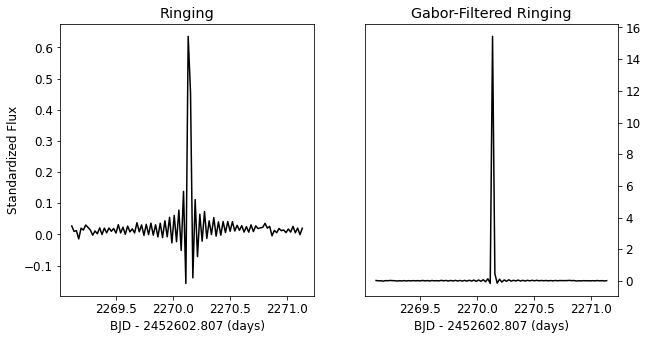

In [225]:
lc = 500
flr = 2022

post_y = gabor_mcmc(bjds[lc], processed[lc], flr)

x = bjds[lc][flr-50:flr+50]
y = processed[lc][flr-50:flr+50]
    
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, y, color='k')
ax[1].plot(x, post_y, color='k')

flrtime = 2454833 - time2[flr]

ax[0].set_title('Ringing')
ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[0].set_ylabel('Standardized Flux')
ax[0].ticklabel_format(useOffset=False, style='plain')


ax[1].set_title('Gabor-Filtered Ringing')
ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[1].yaxis.tick_right()
ax[1].ticklabel_format(useOffset=False, style='plain')
    
print('Ringing amp as fraction of signal: {}'.format(np.abs(post_y.min()/post_y.max())))
    
plt.show()